# Яков 3аграничный РТ5-61Б, Предсказание диабета в Индийском регионе

# Описание набора данных

В качестве набора данных используется датасет [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download)
Для решения задачи классификации был выбран набор данных содержащий информацию о пациентах, которые могут быть подвержены диабету. 

Датасет состоит из одного файла diabetes.csv

В наборе данных присутствуют следующие столбцы:


*  Pregnancies: число беременностей пациента [шт.]

*  Glucose: концентарция глюкозы в крови пациента [%]

*  BloodPressure: кровяное давление [мм рт. ст.]

*  SkinThickness: болезнь(и) сердца [мм]

*  Insulin:  [мм/м]

*  BMI: индекс массы тела [кг/м^2] 

*  DiabetesPedigreeFunction: вероятностьь равития диабета согласно индексу Pedigree []

* Age: вораст пациента [Г]

* Outcome: наличие диабета [1-да, 0-нет]

Будем решать задачу классификации: определять, есть ли у человека диабет или нет.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

# Разведочный анализ данных, визуализация и предобработка данных

## Общая информация о датасете

In [2]:
data = pd.read_csv('diabetes.csv')
data = data.drop_duplicates()

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Размер датасета.

In [4]:
data.shape

(768, 9)

Cписок колонок датасета.

In [5]:
COLUMNS = data.columns
COLUMNS # Пригодится в дальнейшем

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## Проверка на наличие пропусков

Проверка пропусков индекса массы тела.

In [7]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Проверка на дубликаты

In [8]:
data.duplicated().sum()

0

## Визуализация. Разведочный анализ

In [9]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Очевидно, что Outcome будет целевым признаком. Заранее запомним числовые и категориальные признаки.

In [10]:
NUM_COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
TARGET_KEY = 'Outcome'

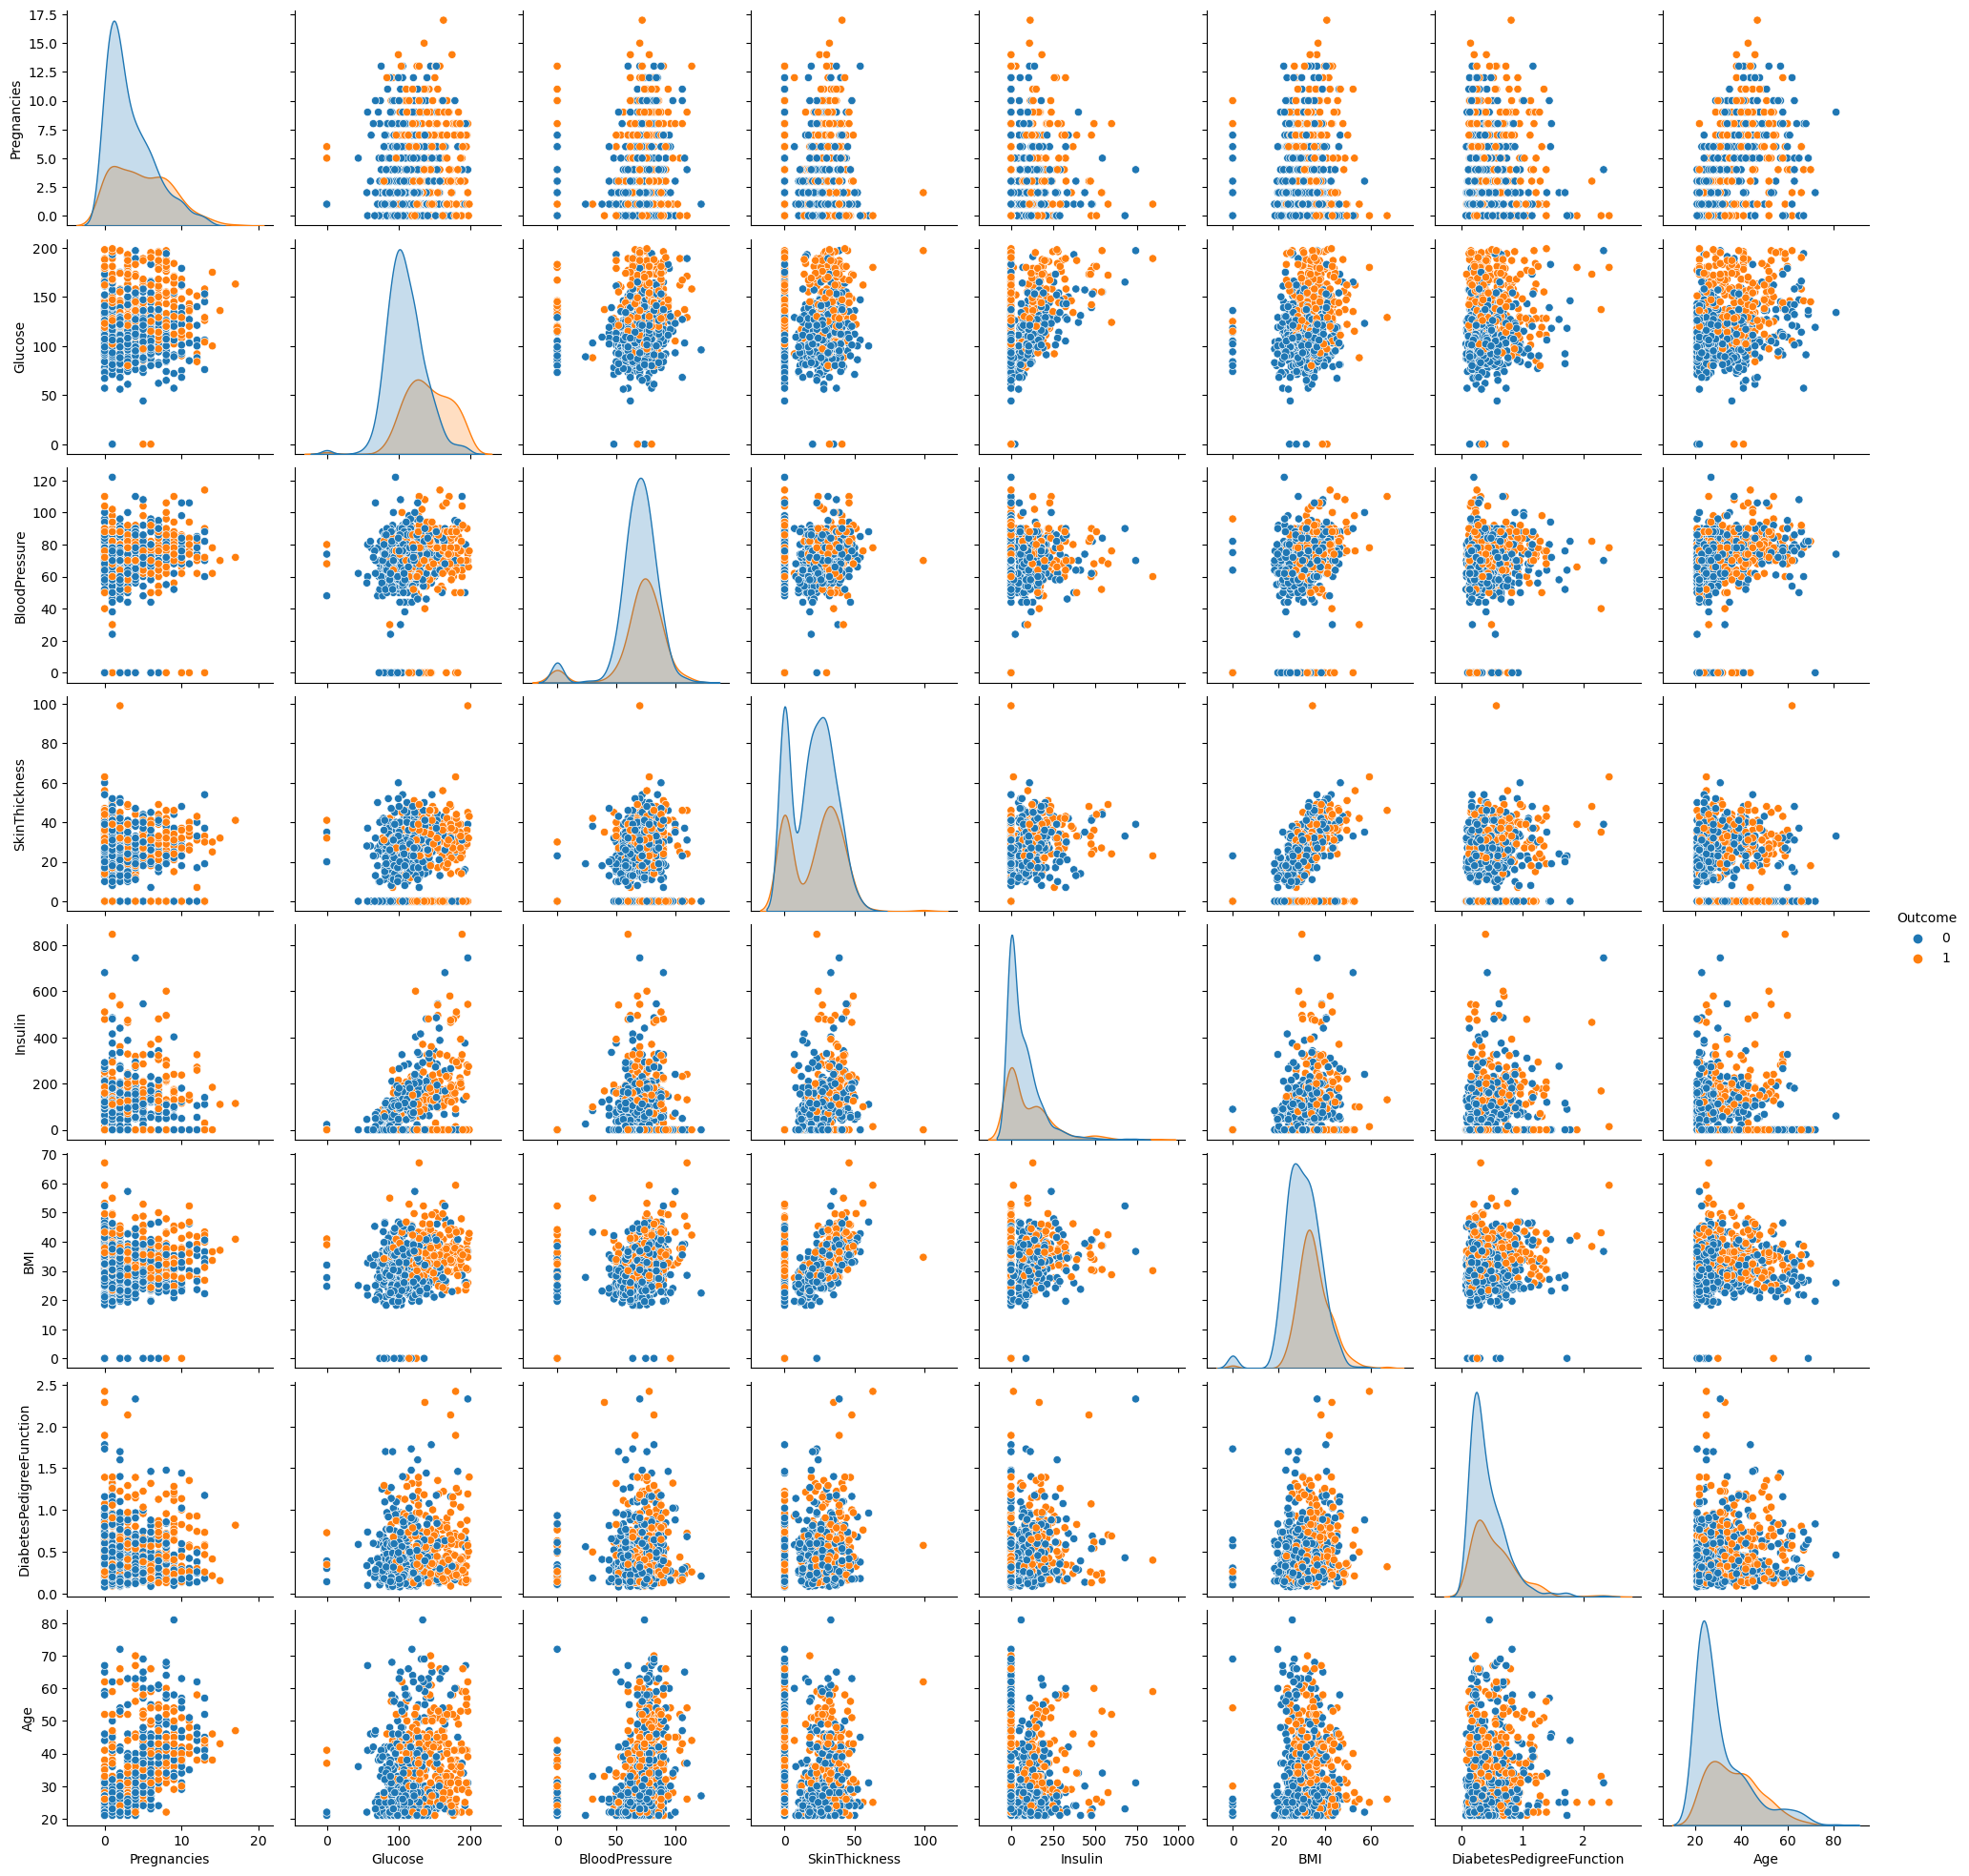

In [11]:
sns.pairplot(data, hue=TARGET_KEY)

In [12]:
data[TARGET_KEY].unique()

array([1, 0], dtype=int64)

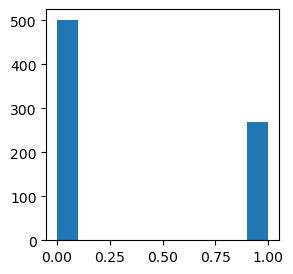

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.hist(data[TARGET_KEY])
plt.show()

In [14]:
total = data.shape[0]
class_0, class_1 = data[TARGET_KEY].value_counts()
print(f'Класс 0: {round(class_0 / total * 100, 2)}%\nКласс 1: {round(class_1 / total * 100, 2)}%')

Класс 0: 65.1%
Класс 1: 34.9%


Классы в датасете сбалансированы

In [15]:
data.groupby(data.Outcome).mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


Предположения на основании поиска среденего значения с группировкой по целевому признаку:
Очеввидно, риск диабета увеличивается с ростом следующих параметров:
* Возраст
* Число беременностей
* Индекс массы тела и толщина кожно-жировой прослойки
* Уровень исулина
* Уровнень глюкозы
* Кровяное давление
* Индекс Pedigree
    


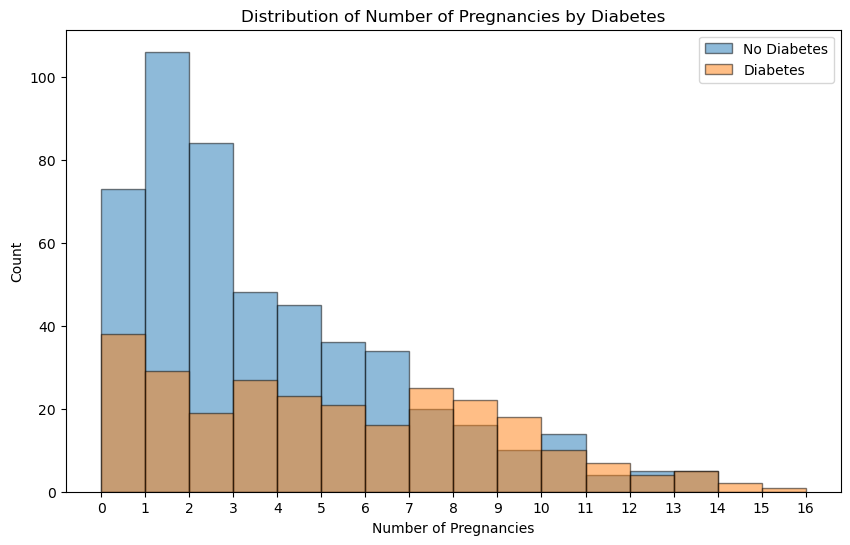

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

with_diabetes = data[data['Outcome'] == 1]['Pregnancies']
no_diabetes = data[data['Outcome'] == 0]['Pregnancies']

# Создаем bins на основе уникальных значений количества беременностей
bins = range(int(data['Pregnancies'].min()), int(data['Pregnancies'].max()))

plt.figure(figsize=(10, 6))
plt.hist(no_diabetes, bins=bins, alpha=0.5, label='No Diabetes', edgecolor='black')
plt.hist(with_diabetes, bins=bins, alpha=0.5, label='Diabetes', edgecolor='black')

plt.xlabel('Number of Pregnancies')
plt.ylabel('Count')
plt.title('Distribution of Number of Pregnancies by Diabetes')
plt.xticks(bins)  # Устанавливаем дискретные значения на оси x

plt.legend()
plt.show()

Если учесть раницу масштабов, то можно скаать, что у людей с диабетом было больше родов. Соответсвенно, можно считать, что чем больше было родов, тем больше вероятность диабета.

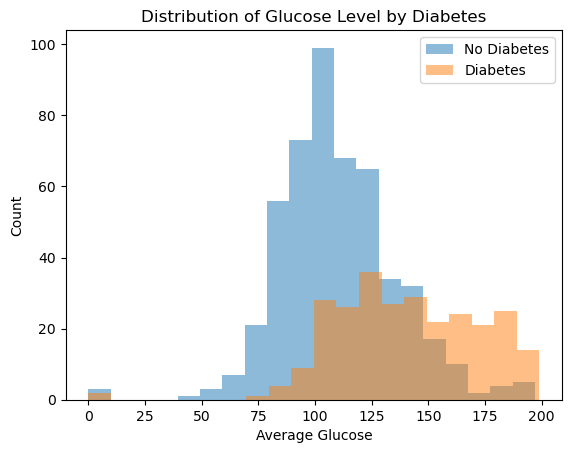

In [17]:
with_diabetes = data[data['Outcome'] == 1]['Glucose']
no_diabetes = data[data['Outcome'] == 0]['Glucose']

plt.hist(no_diabetes, bins=20, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=20, alpha=0.5, label='Diabetes')

plt.xlabel('Average Glucose')
plt.ylabel('Count')
plt.title('Distribution of Glucose Level by Diabetes')
plt.legend()

plt.show()

Большая часть тех, кто страдает диабетом, имеет повышенный уровень глюкозы, следовательно, люди, у которых повышен уровень глюкоы с большей вероятностью страдают диабетом.

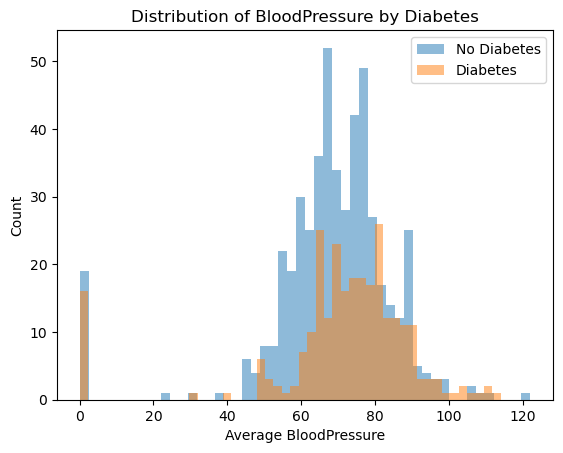

In [18]:
with_diabetes = data[data['Outcome'] == 1]['BloodPressure']
no_diabetes = data[data['Outcome'] == 0]['BloodPressure']

plt.hist(no_diabetes, bins=50, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=50, alpha=0.5, label='Diabetes')

plt.xlabel('Average BloodPressure')
plt.ylabel('Count')
plt.title('Distribution of BloodPressure by Diabetes')
plt.legend()

plt.show()

Люди, имеющие диабет имеют несколько большее кровяное давление. 
Следовательно, люди с большим кровяным давлением имеют повыешнный риск диабета.

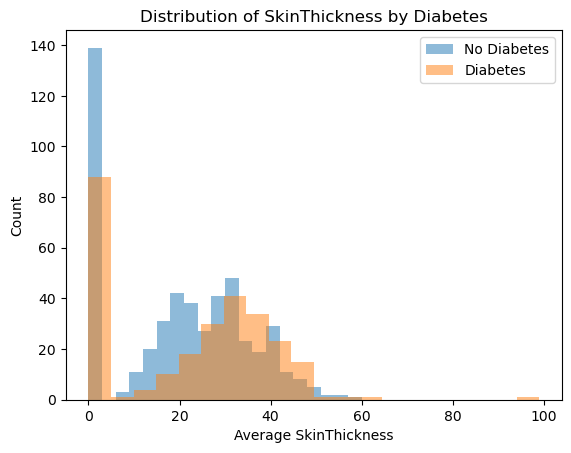

In [19]:
with_diabetes = data[data['Outcome'] == 1]['SkinThickness']
no_diabetes = data[data['Outcome'] == 0]['SkinThickness']

plt.hist(no_diabetes, bins=20, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=20, alpha=0.5, label='Diabetes')

plt.xlabel('Average SkinThickness')
plt.ylabel('Count')
plt.title('Distribution of SkinThickness by Diabetes')
plt.legend()

plt.show()

Люди с диабетом имеют несколько большую толщину кожно-жировой прослойки. 
Следовательно люди с повыешнной ее толщиной с большим риском страдают диабетом. 

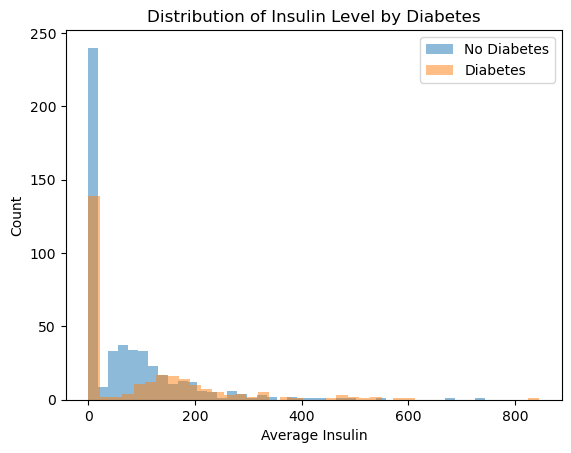

In [20]:
with_diabetes = data[data['Outcome'] == 1]['Insulin']
no_diabetes = data[data['Outcome'] == 0]['Insulin']

plt.hist(no_diabetes, bins=40, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=40, alpha=0.5, label='Diabetes')

plt.xlabel('Average Insulin')
plt.ylabel('Count')
plt.title('Distribution of Insulin Level by Diabetes')
plt.legend()

plt.show()

Люди с диаетом имеют нескоклько повышенный уровень инсулина. 
Следовательно, люди с повышенным уровнем инсулина с большим риском страдают диабетом. 

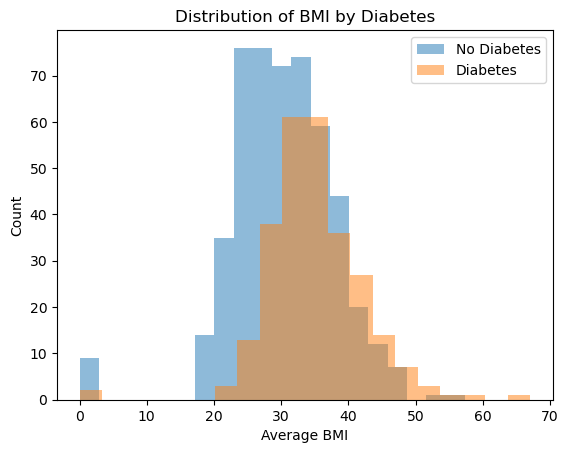

In [21]:
with_diabetes = data[data['Outcome'] == 1]['BMI']
no_diabetes = data[data['Outcome'] == 0]['BMI']

plt.hist(no_diabetes, bins=20, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=20, alpha=0.5, label='Diabetes')

plt.xlabel('Average BMI')
plt.ylabel('Count')
plt.title('Distribution of BMI by Diabetes')
plt.legend()

plt.show()

Аналогично с индексом массы тела - у больных диабетом он в среднем выше. 
Следовательно, люди с более высоким индексом массы с большим риском страдают диабетом.

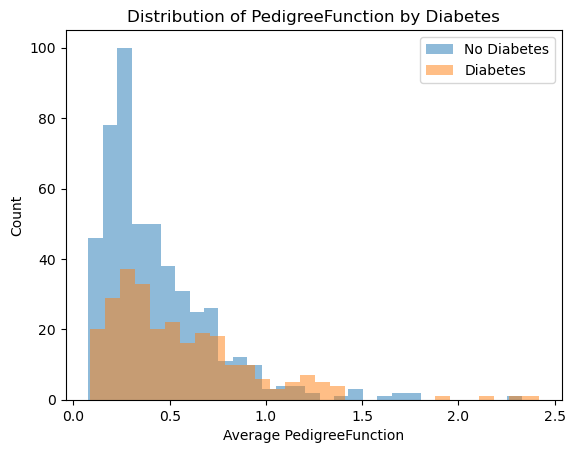

In [22]:
with_diabetes= data[data['Outcome'] == 1]['DiabetesPedigreeFunction']
no_diabetes = data[data['Outcome'] == 0]['DiabetesPedigreeFunction']

plt.hist(no_diabetes, bins=30, alpha=0.5, label='No Diabetes')
plt.hist(with_diabetes, bins=30, alpha=0.5, label='Diabetes')

plt.xlabel('Average PedigreeFunction')
plt.ylabel('Count')
plt.title('Distribution of PedigreeFunction by Diabetes')
plt.legend()

plt.show()

С учетом разницы в масштабах, более высокое значение функции Педигри действительно соответсвует большей вероятности диабета.  

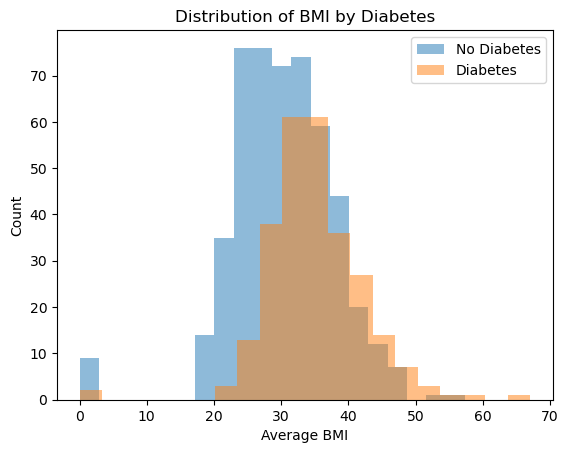

In [23]:
glucose_stroke = data[data['Outcome'] == 1]['BMI']
glucose_no_stroke = data[data['Outcome'] == 0]['BMI']

plt.hist(glucose_no_stroke, bins=20, alpha=0.5, label='No Diabetes')
plt.hist(glucose_stroke, bins=20, alpha=0.5, label='Diabetes')

plt.xlabel('Average BMI')
plt.ylabel('Count')
plt.title('Distribution of BMI by Diabetes')
plt.legend()

plt.show()

Как можно видеть, люди большего вораста с большей вероятностью страдают диабетом. 

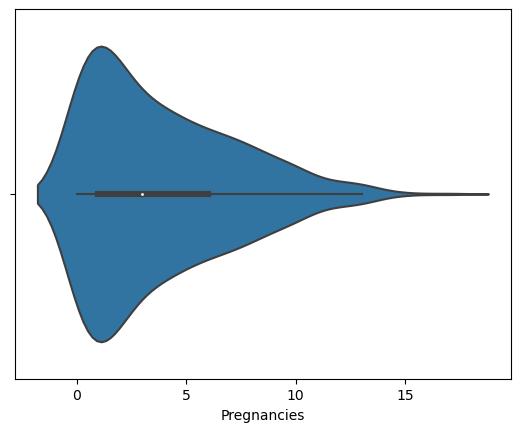

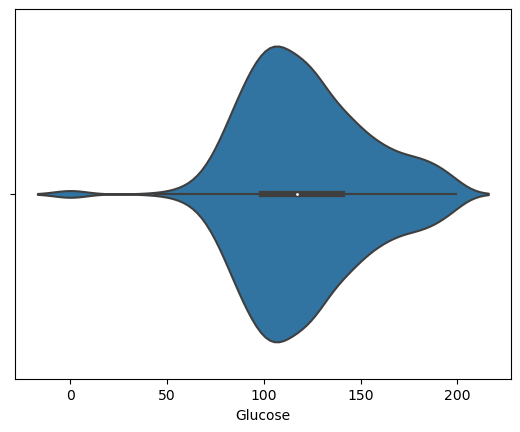

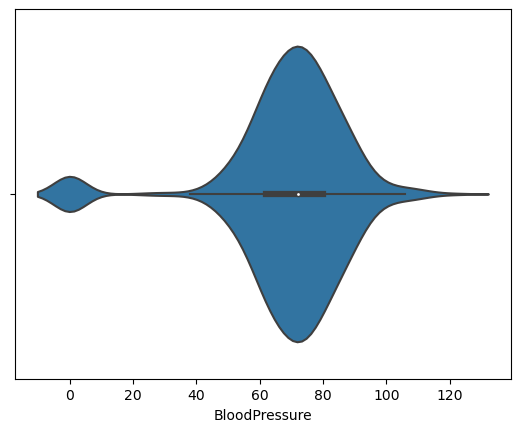

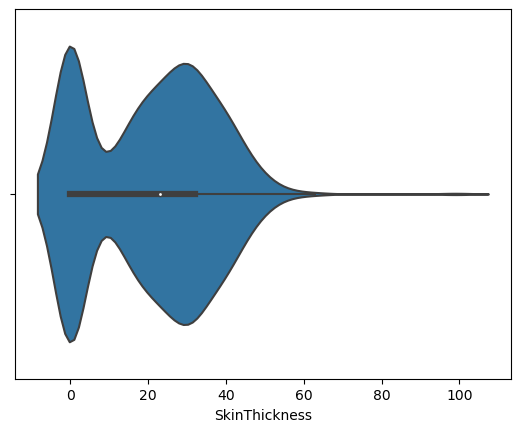

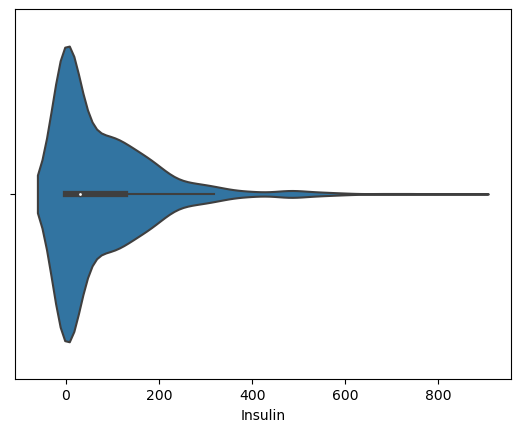

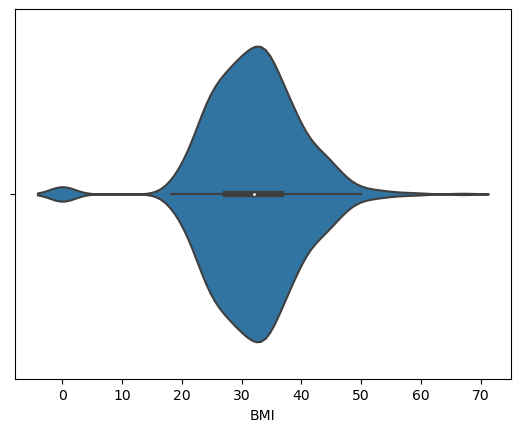

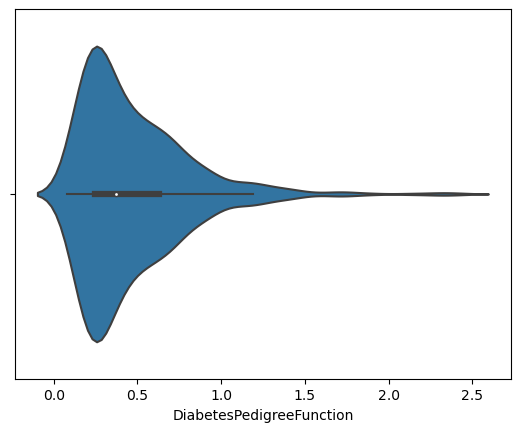

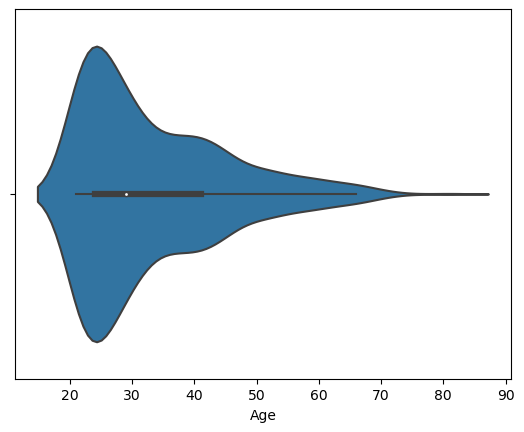

In [24]:
for col in NUM_COLUMNS:
    sns.violinplot(x=data[col])
    plt.show()


### Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

## Масштабирование

Посмотрим на распредление колонок, которые будем масштабировать. Промасштабируем. Убедимся, что распределение не изменилось. Категориальные признаки отсутствуют, необходимости в кодировании нет.  

In [25]:
mms = MinMaxScaler()
le = LabelEncoder()
data_scaled = data.copy()

for col in NUM_COLUMNS:
    data_scaled[col] = mms.fit_transform(data[[col]])

data_scaled.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1


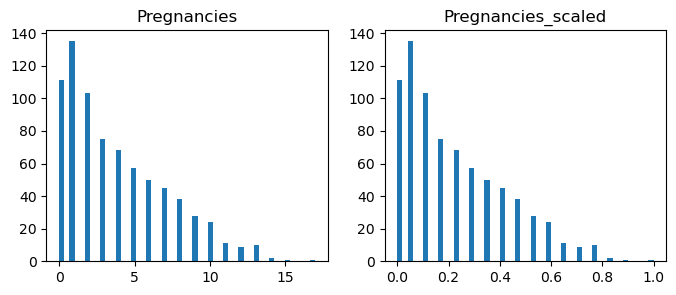

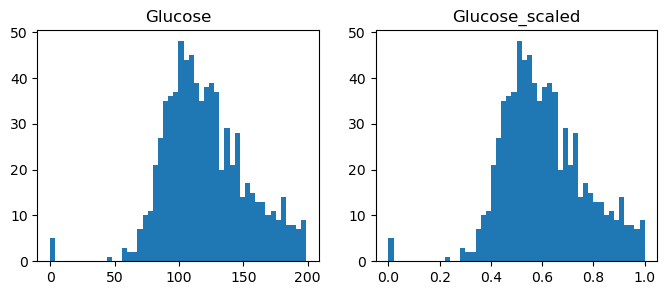

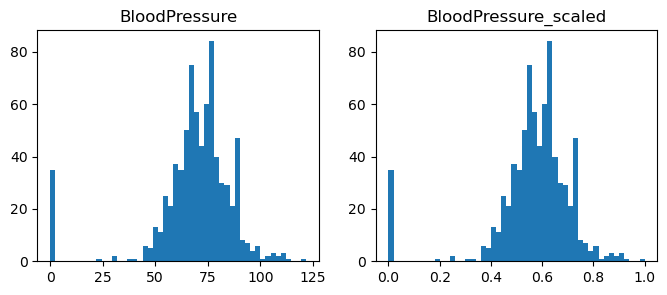

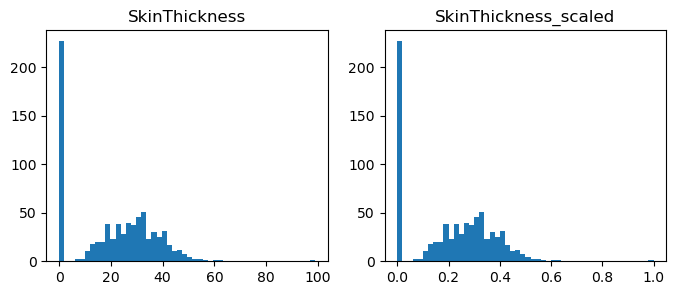

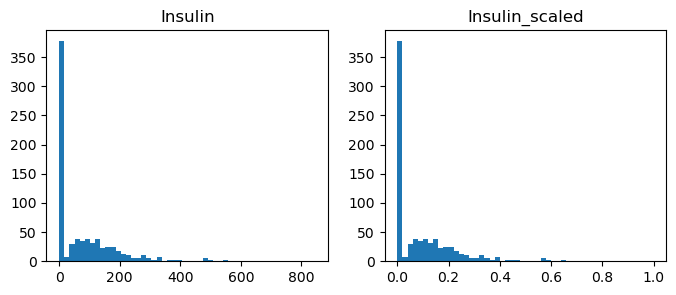

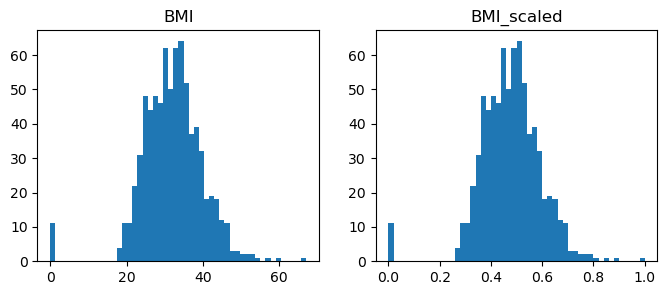

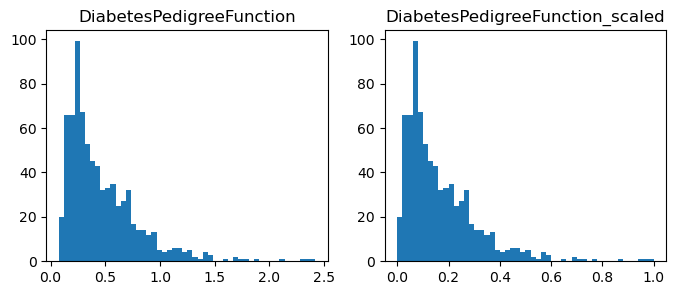

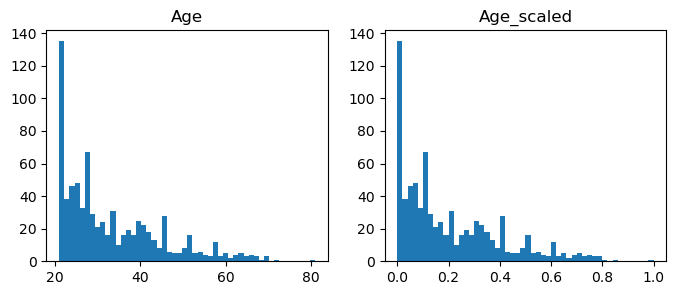

In [26]:
for col in NUM_COLUMNS:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data_scaled[col], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

**Масштабирование данных не повлияло на их распределение.**

In [27]:
data = data_scaled

### Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

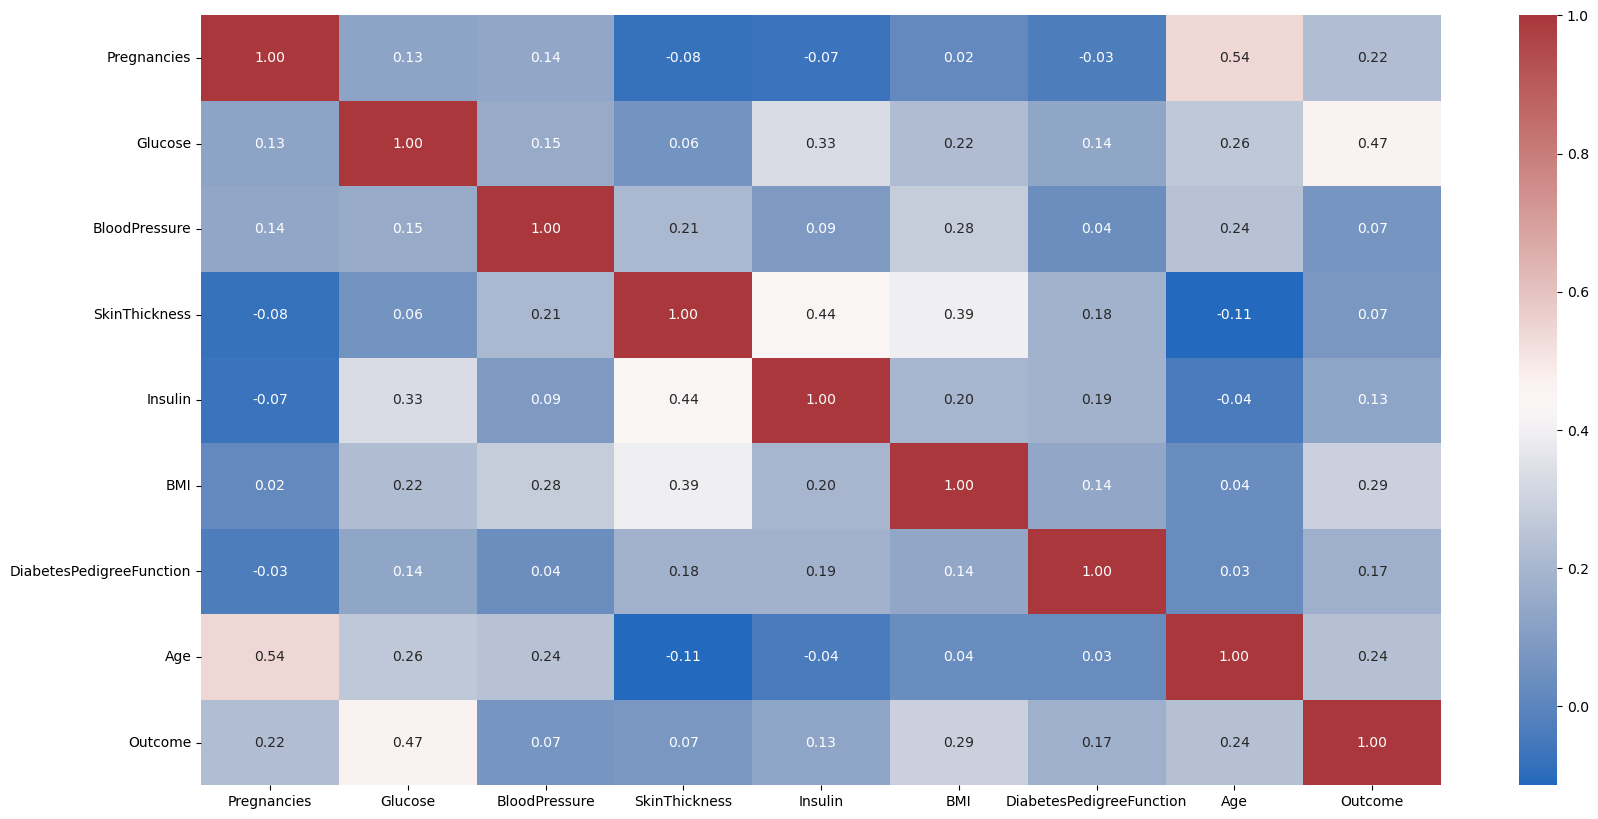

In [28]:
my_cmap=sns.color_palette('vlag', as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap=my_cmap)
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

* Целевой признак больше всего коррелирует с уровнем глюкозы;
* Из нецелевых принаков можно увидеть ряд очевидных закономерностей:
    1. Возраст связан с счислом беременностей;
    2. Инждекс массы тела свяан с толщиной кожно-жировой прослойки;
    3. Уровень инсулина свяан с уровнем глюкозы;
* Нетривиальной связью явяется свяь толщины кожно-жировой прослойки с уровнем инсулина - эта связь сильнее, чем с индексом массы  
    

In [29]:
data = data.drop(columns=['BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'Insulin'])
data.head()

,Pregnancies,Glucose,BMI,Age,Outcome
0,0.352941,0.743719,0.500745,0.483333,1
1,0.058824,0.427136,0.396423,0.166667,0
2,0.470588,0.919598,0.347243,0.183333,1
3,0.058824,0.447236,0.418778,0.000000,0
4,0.000000,0.688442,0.642325,0.200000,1


### Выбор метрик для последующей оценки качества моделей.

Будем использовать метрики:
- Метрика balanced accuracy: Использоваться будет функция [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html)
- Метрика $F_1$-мера: метрика как среднее гармоническое precision и recall позволяет учитывать обе эти метрики одновременно. Использоваться будет функция [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- Метрика ROC AUC: площадь под графиком ROC-кривой позволяет оценить качество модели, учитывая True Positive Rate и False Positive Rate. Использоваться будет функция [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

### Выбор наиболее подходящих моделей для решения задачи классификации.

Будут использованы модели:
- Метод k ближайших соседей
- Логистическая регрессия
- Метод опорных векторов
- Случайный лес
- Градиентный бустинг

### Формирование обучающей и тестовой выборок на основе исходного набора данных.

Выделим из исходного набора данных обучающую и тестовую выборки.

In [30]:
X_data, y_data = data.drop(columns=[TARGET_KEY]), data[[TARGET_KEY]]
X_test, X_train, y_test, y_train = train_test_split(X_data, y_data, shuffle=True, stratify=y_data)

### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров.

Для создания моделей с параметрами, их обучения, сохранения предсказаний, вычисления и визулизации метрик был насписан класс ModelList.

In [31]:
class ModelList:
    def __init__(self, **models):
        self.__model_keys = list(models.keys())
        self.__model_classes = models
        self.__model_params = {key: {} for key in self.__model_keys}
        self.__metric_labels = []
        self.__metric_fns = {}
        self.__model_metrics = {key: {} for key in self.__model_keys}
        self.__models = {}
        self.__model_pred = {}
        self.X_test = None
        self.y_test = None
        self.X_train = None
        self.y_train = None

    def set_params(self, model_key: str, **params):
        try:
            self.__models[model_key]
            return
        except:
            self.__model_params[model_key] = params

    def set_metrics(self, **metrics):
        for key in metrics:
            self.__metric_fns[key] = metrics[key]
            self.__metric_labels += [key]

    def predict(self, model_key: str  = None):
        if model_key:
            self.__model_pred[model_key] = self.__models[model_key].predict(self.X_test)
            return
        for key in self.__model_keys:
            self.__model_pred[key] = self.__models[key].predict(self.X_test)

    def fit(self, model_key: str  = None):
        if model_key:
            self.__models[model_key].fit(self.X_train, self.y_train.to_numpy().flatten())
        for key in self.__model_keys:
            self.__models[key].fit(self.X_train, self.y_train.to_numpy().flatten())


    def initialize(self, model_key: str = None):
        if model_key:
            self.__models[model_key] = self.__model_classes[model_key](**self.__model_params[model_key])
            return
        for key in self.__model_keys:
            self.__models[key] = self.__model_classes[key](**self.__model_params[key])

    @property
    def keys(self):
        return self.__model_keys
    
    @property
    def predictions(self):
        return self.__model_pred

    @property
    def classes(self):
        return self.__model_classes
    
    @property
    def metrics(self):
        return self.__metric_labels

    def __getitem__(self, model_key: str):
        return self.__models[model_key]

    def __setitem__(self, model_key: str, value):
        self.__model_keys += [model_key]
        self.__model_classes[model_key] = value
        self.__model_params[model_key] = {}
        self.__model_metrics[model_key] = {}

    def __iter__(self):
        return iter(self.__models.items())
    
    def __draw_roc_curve(self, y_true, y_score, ax):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc_value = roc_auc_score(y_true, y_score)
        lw = 2
        ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_xlim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic')
        ax.legend(loc="lower right")

    def get_model_metrics(self, model_key):
        y_pred_proba = self.__models[model_key].predict_proba(self.X_test)
        y_pred_proba = y_pred_proba[:,1]
    
        for metric_label in self.__metric_labels:
            self.__model_metrics[model_key][metric_label] = self.__metric_fns[metric_label](self.y_test, self.__model_pred[model_key])

        fig, ax = plt.subplots(ncols=2, figsize=(20,10))
        self.__draw_roc_curve(self.y_test, y_pred_proba, ax[0])
        ConfusionMatrixDisplay.from_predictions(y_test, self.__model_pred[model_key], ax=ax[1], cmap=sns.color_palette("YlOrBr", as_cmap=True), normalize='true')
        fig.suptitle(model_key)
        plt.show()

    def plot_metrics(self, metric_label):
        metric_values = sorted([(model_key, self.__model_metrics[model_key][metric_label]) for model_key in self.__model_keys], key=lambda x: x[1])
        metric_models = [model_name for model_name, _ in metric_values]
        metric_scores = [model_score for _, model_score in metric_values]
        _, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlim([0, 1])
        pos = np.arange(len(self.__model_keys))
        ax.barh(pos, metric_scores,
                    align='center',
                    height=0.5, 
                    tick_label=metric_models)
        ax.set_title(metric_label)
        for x, y in zip(pos, metric_scores):
            plt.text(0.01, x-0.05, str(round(y,3)), color='white').set_bbox({
                  'facecolor': 'black'
            })
        plt.show()

In [32]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
model_list = ModelList(KNN=KNeighborsClassifier, LR=LogisticRegression, SVC=SVC, RF=RandomForestClassifier, GB=GradientBoostingClassifier)
model_list.X_train = X_train
model_list.y_train = y_train
model_list.X_test = X_test
model_list.y_test = y_test
model_list.set_params('SVC', probability=True)
model_list.initialize()
model_list.fit()

model_list.predict()

### Вычисление метрик для каждой модели, отрисовка ROC-кривых и матриц ошибок. 

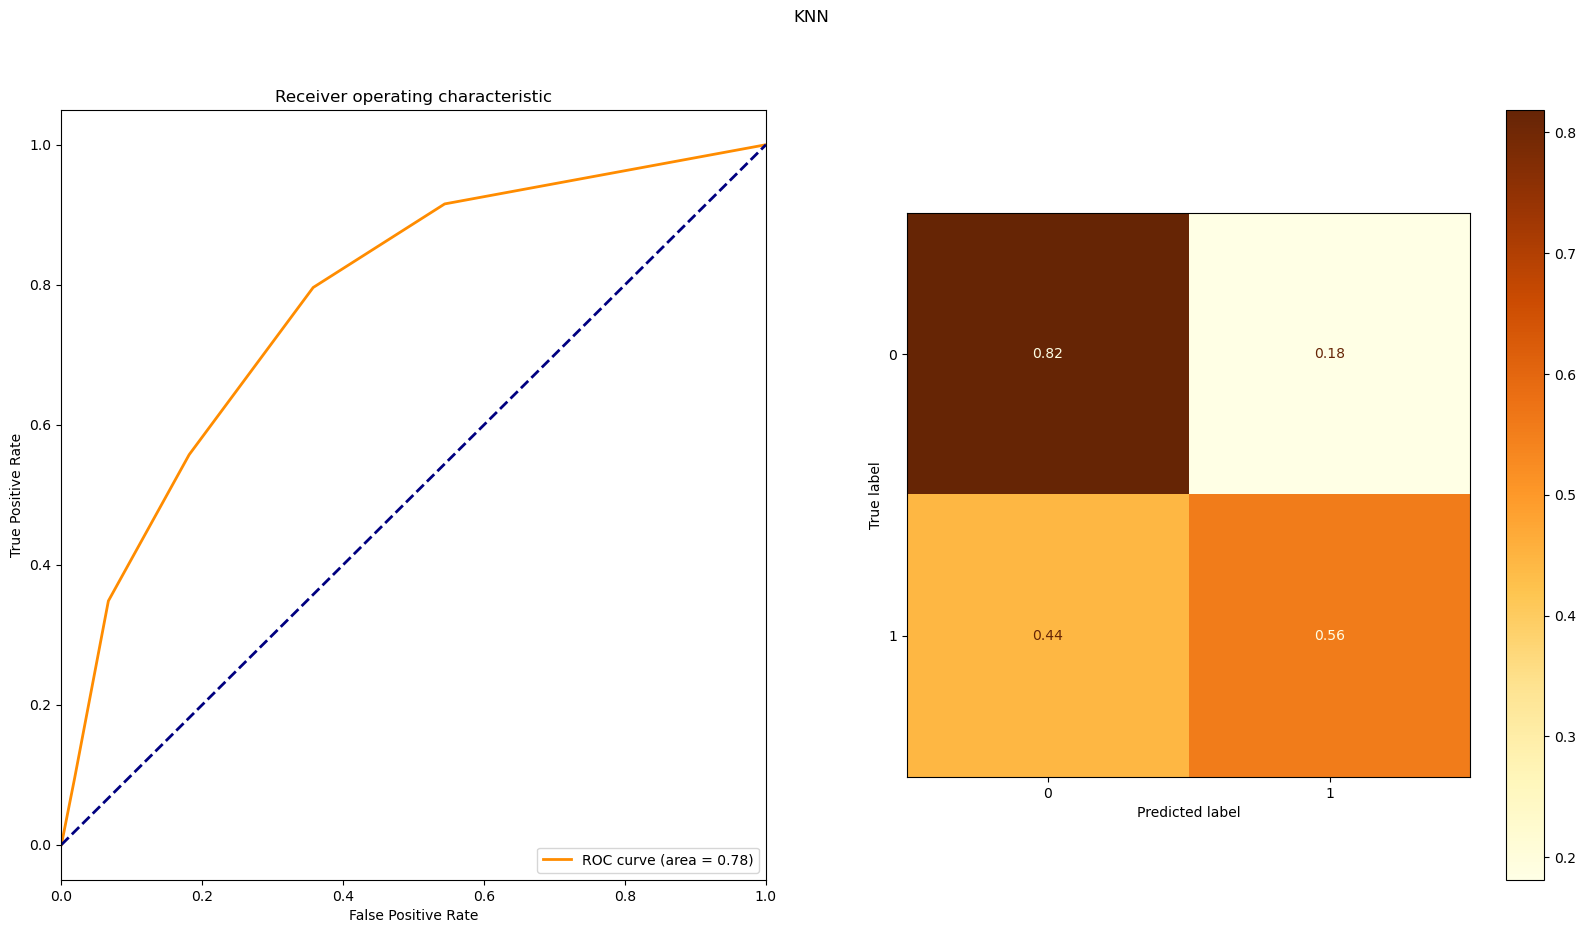

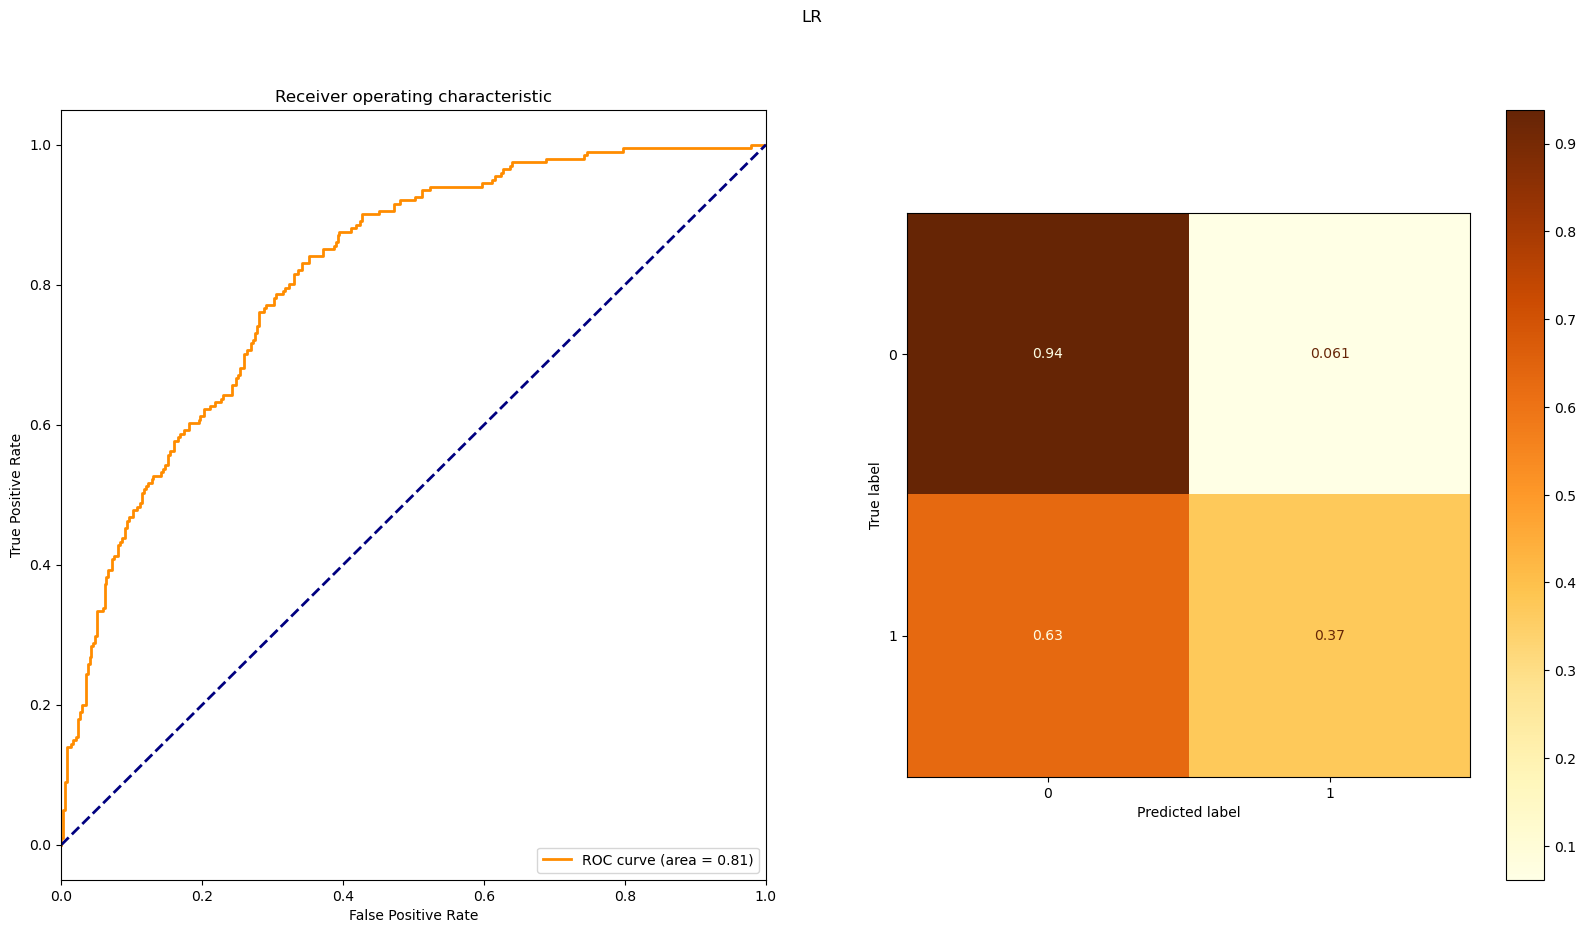

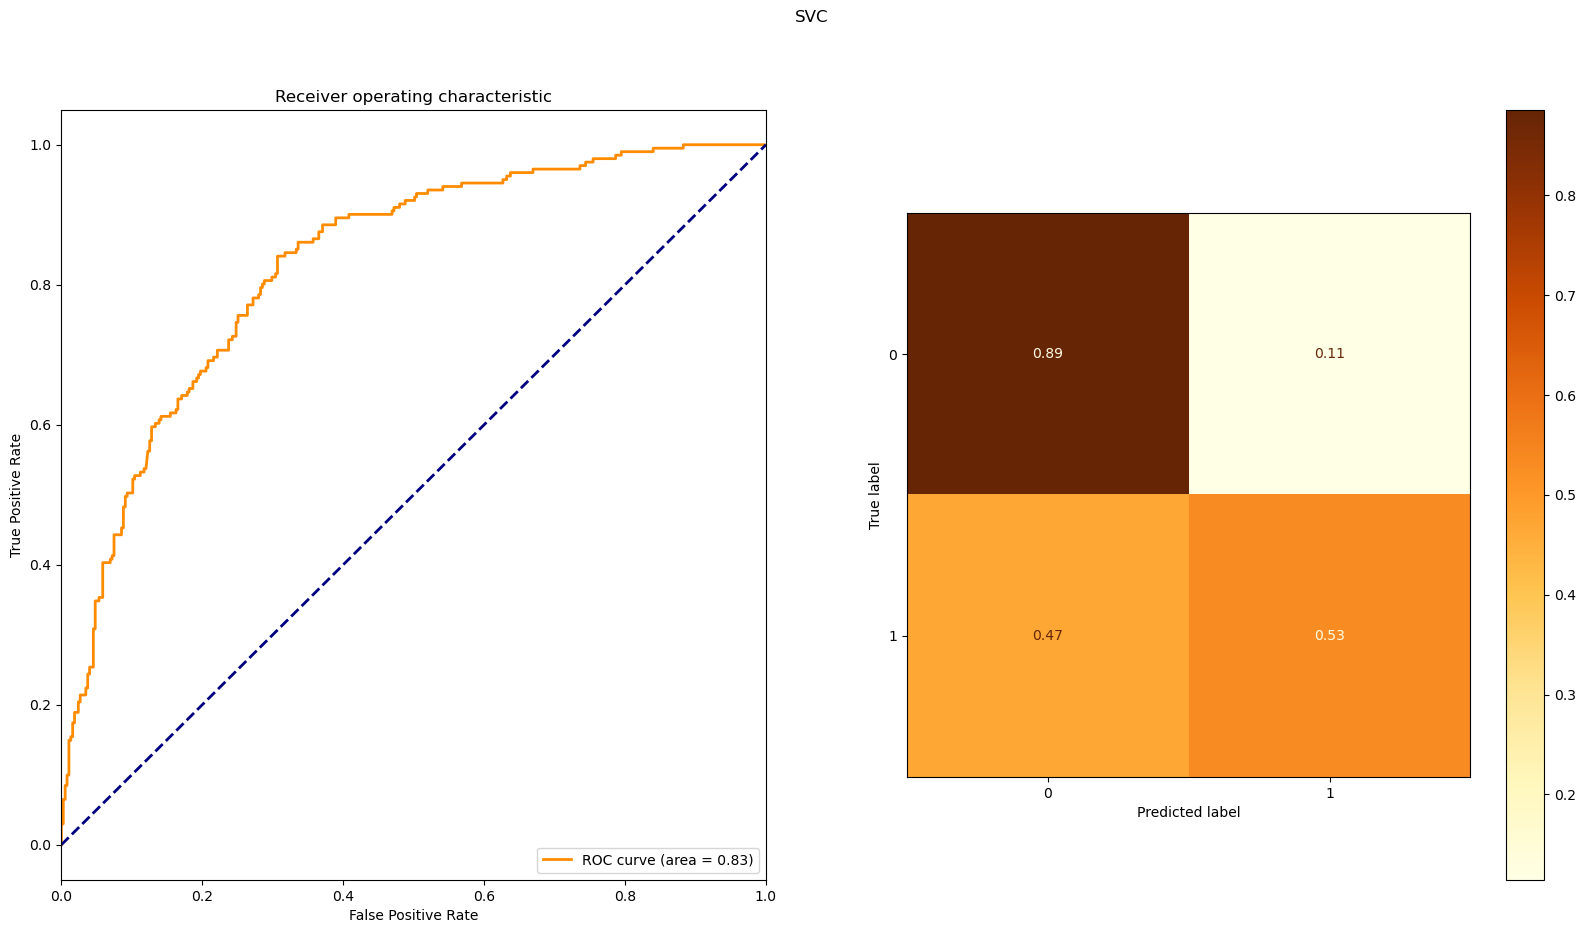

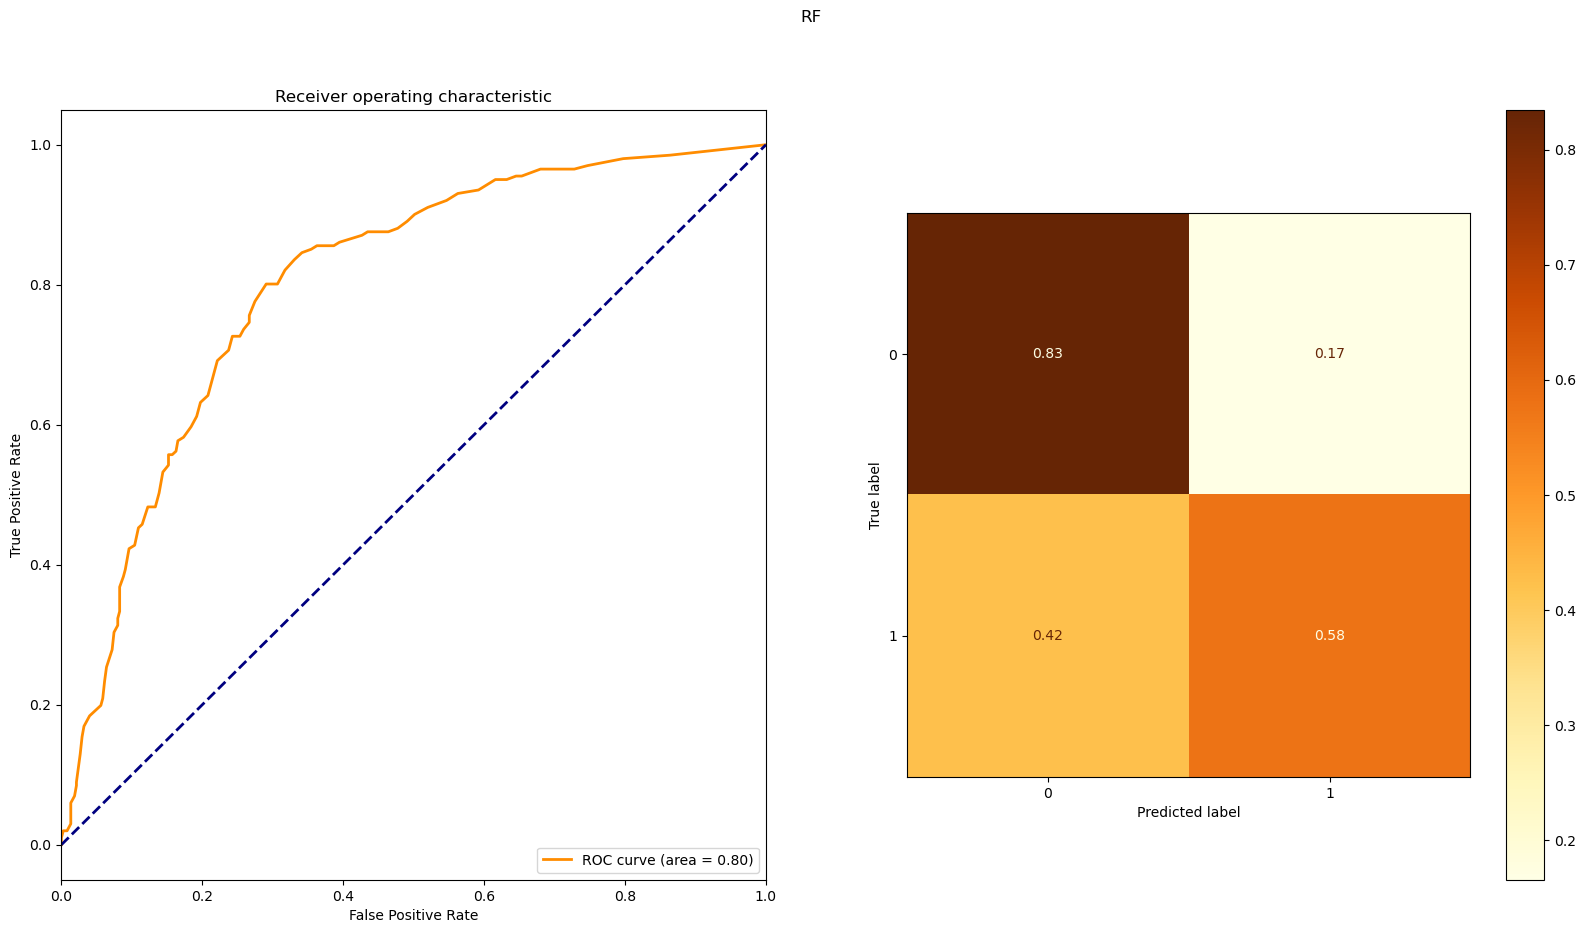

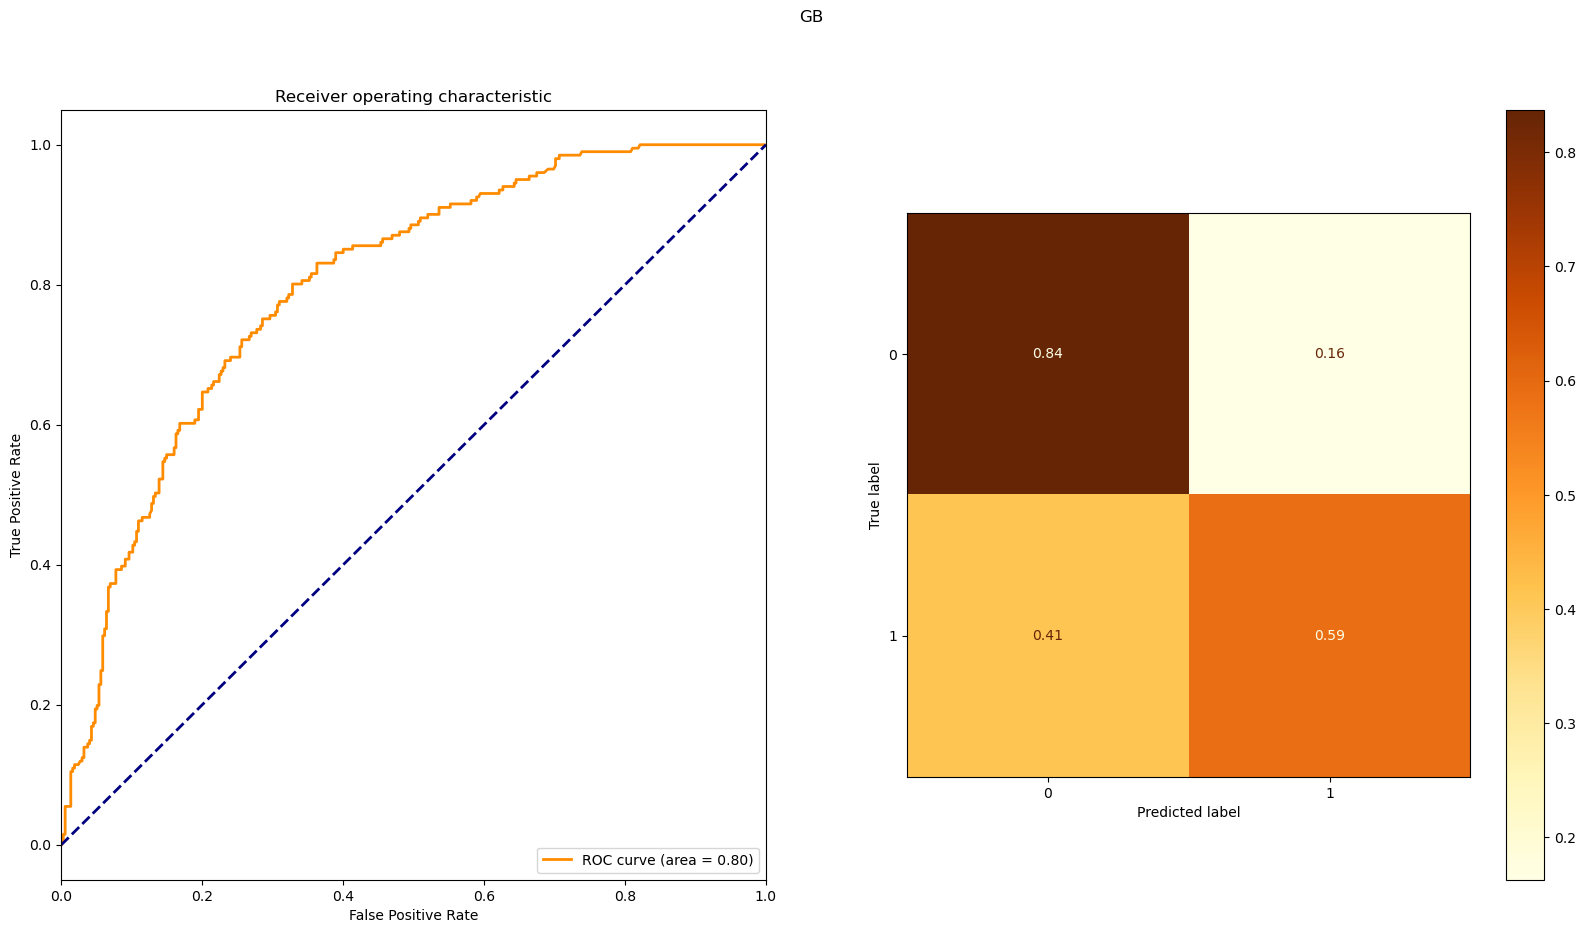

In [33]:
model_list.set_metrics(balanced_accuracy=balanced_accuracy_score, f1=f1_score, roc_auc=roc_auc_score)
for key in model_list.keys:
    model_list.get_model_metrics(key)

### Подбор гиперпараметров для выбранных моделей с использованием RandomizedSearchCV.

Создаем новую модель метода ближайших соседей, подбираем лучшие параметры.

In [34]:
model_list['KNN_OPT'] = KNeighborsClassifier

n_range = list(range(1, 50))
weights_range = ['uniform', 'distance']
p_range = [1, 2]
param_grid = dict(n_neighbors=n_range, weights=weights_range, p=p_range)

rs = RandomizedSearchCV(model_list.classes['KNN_OPT'](), param_grid, scoring='balanced_accuracy')
random_search=rs.fit(X_train.to_numpy(), y_train.to_numpy().flatten())

best_n = random_search.best_params_['n_neighbors']
best_weights = random_search.best_params_['weights']
best_p = random_search.best_params_['p']
best_n, best_weights, best_p

(16, 'distance', 2)

Устанавливаем модели найденные лучшие параметры, вычисляем значения метрик, выводим графики для сравнения с baseline-моделью.

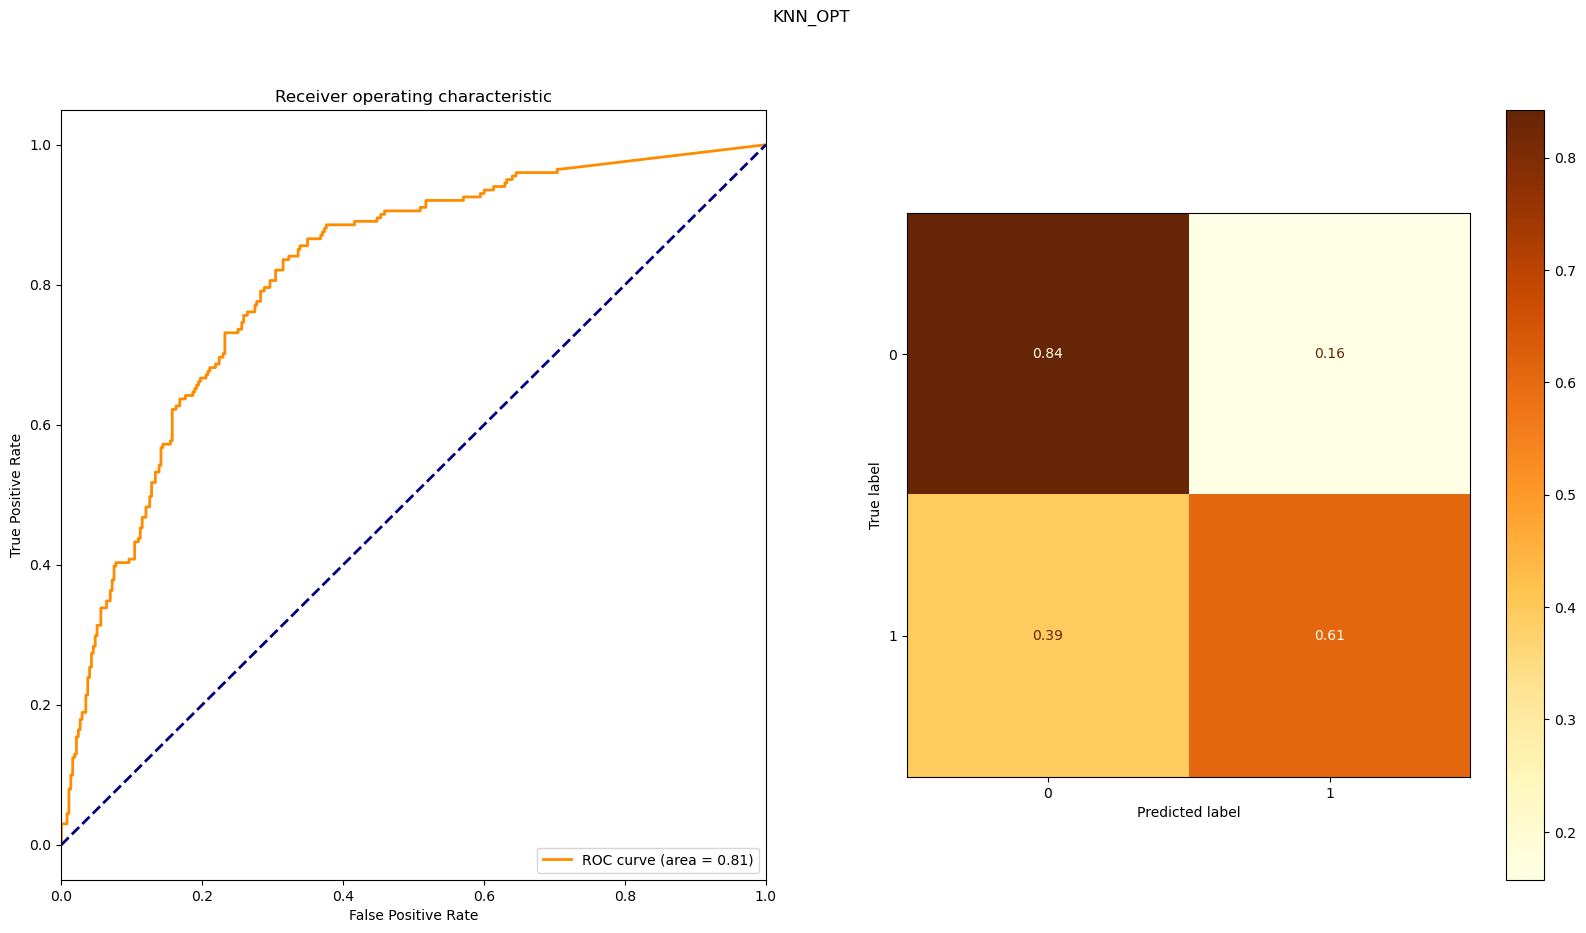

In [36]:
model_list.set_params('KNN_OPT', n_neighbors=best_n, weights=best_weights, p=best_p)
model_list.initialize(model_key='KNN_OPT')
model_list.fit(model_key='KNN_OPT')
model_list.predict(model_key='KNN_OPT')

model_list.get_model_metrics('KNN_OPT')

Создаем новую модель логистической регрессии, подбираем лучшие параметры.

In [37]:
model_list['LR_OPT'] = LogisticRegression

C_range = [float(10**(power / 100)) for power in range(-200, 201)]
solver_range = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
class_weight_range = [{0: i, 1: 1000 - i} for i in range(1, 1000)]
param_grid = dict(C=C_range, solver=solver_range, class_weight=class_weight_range)

rs = RandomizedSearchCV(model_list.classes['LR_OPT'](), param_grid, scoring='balanced_accuracy')
random_search=rs.fit(X_train.to_numpy(), y_train.to_numpy().flatten())

best_C = random_search.best_params_['C']
best_solver = random_search.best_params_['solver']
best_class_weight = random_search.best_params_['class_weight']
best_C, best_solver, best_class_weight

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

(0.4897788193684462, 'newton-cg', {0: 369, 1: 631})

Устанавливаем модели найденные лучшие параметры, вычисляем значения метрик, выводим графики для сравнения с baseline-моделью.

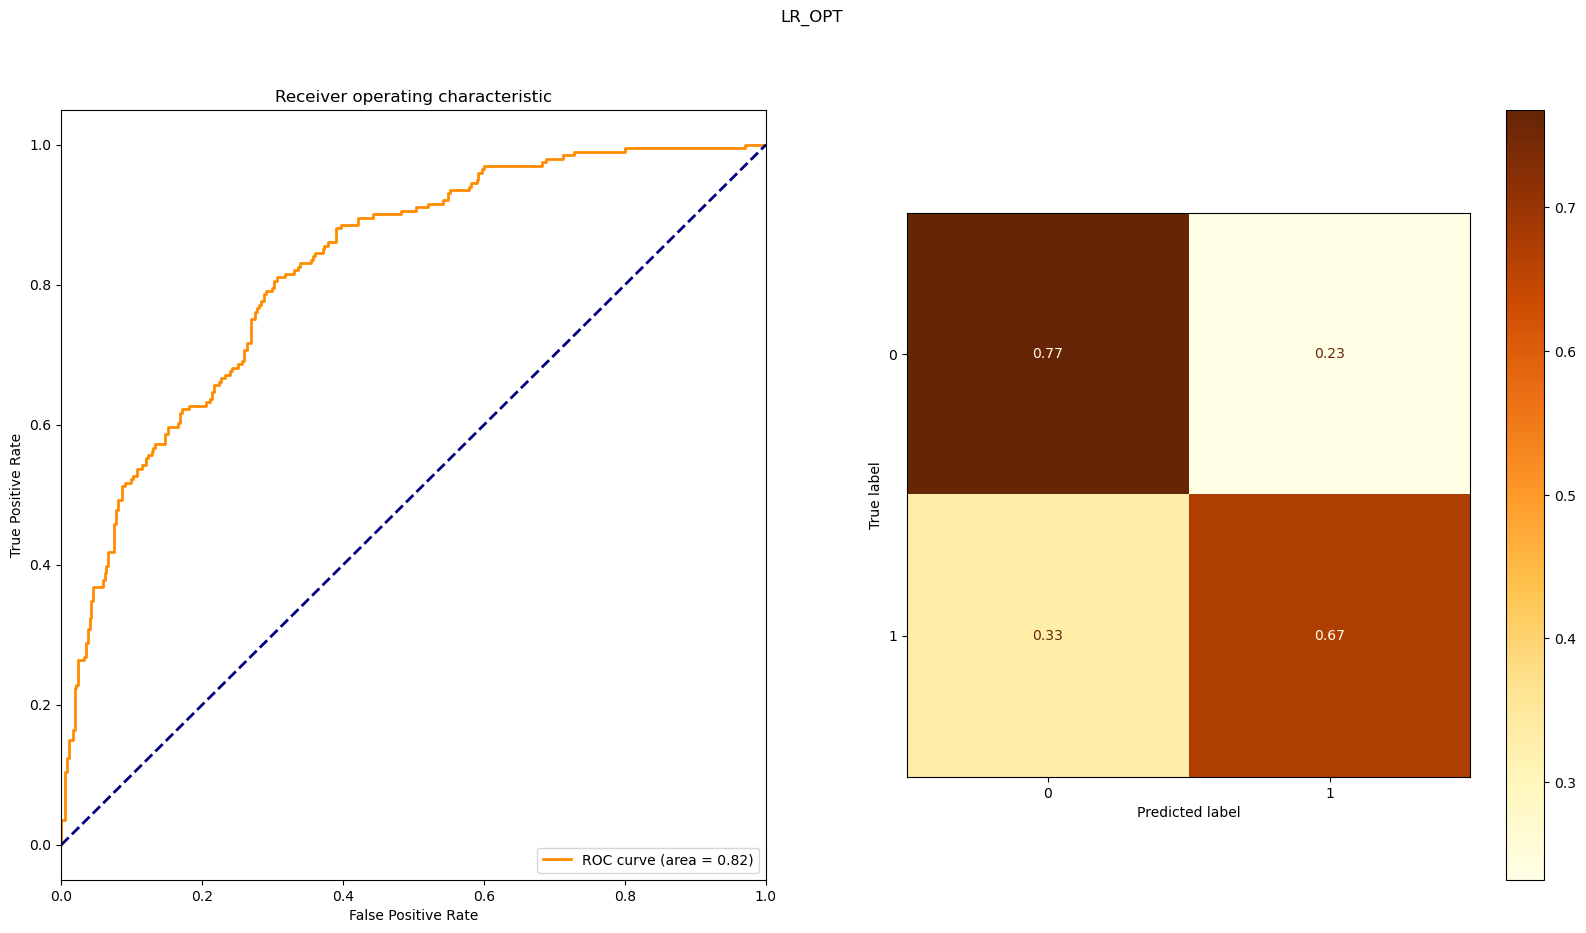

In [38]:
model_list.set_params('LR_OPT', C=best_C, solver=best_solver, class_weight=best_class_weight)
model_list.initialize(model_key='LR_OPT')
model_list.fit(model_key='LR_OPT')
model_list.predict(model_key='LR_OPT')

model_list.get_model_metrics('LR_OPT')

Создаем новую модель метода опорных векторов, подбираем лучшие параметры.

In [39]:
model_list['SVC_OPT'] = SVC

C_range = [float(10**(power / 100)) for power in range(-200, 201)]
kernel_range = ['linear', 'poly', 'rbf', 'sigmoid']
class_weight_range = [{0: i, 1: 1000 - i} for i in range(1, 1000)]
param_grid = dict(C=C_range, kernel=kernel_range, class_weight=class_weight_range)

rs = RandomizedSearchCV(model_list.classes['SVC_OPT'](), param_grid, scoring='balanced_accuracy')
random_search=rs.fit(X_train.to_numpy(), y_train.to_numpy().flatten())

best_C = random_search.best_params_['C']
best_kernel = random_search.best_params_['kernel']
best_class_weight = random_search.best_params_['class_weight']
best_C, best_kernel, best_class_weight

(0.660693448007596, 'poly', {0: 294, 1: 706})

Устанавливаем модели найденные лучшие параметры, вычисляем значения метрик, выводим графики для сравнения с baseline-моделью.

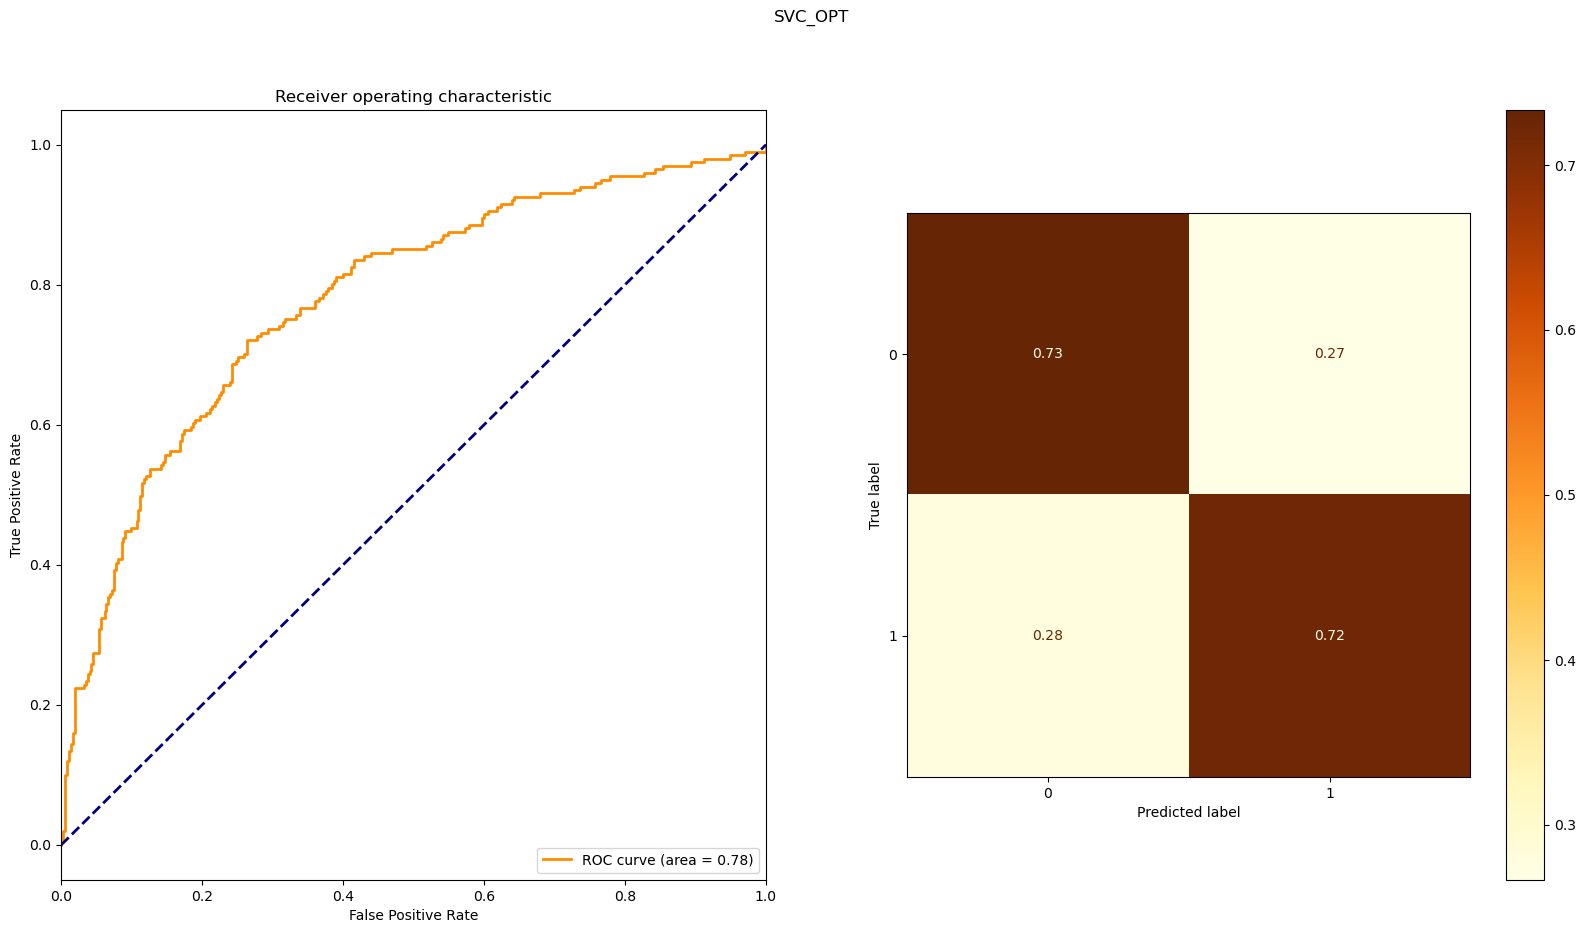

In [40]:
model_list.set_params('SVC_OPT', C=best_C, kernel=best_kernel, class_weight=best_class_weight, probability=True)
model_list.initialize(model_key='SVC_OPT')
model_list.fit(model_key='SVC_OPT')
model_list.predict(model_key='SVC_OPT')

model_list.get_model_metrics('SVC_OPT')

Создаем новую модель случайного леса, подбираем лучшие параметры.

In [41]:
model_list['RF_OPT'] = RandomForestClassifier

n_range = [int(10**(i / 10)) for i in range(0, 31)]
features_range = [None, 'sqrt', 'log2']
criterion_range = ['gini', 'entropy', 'log_loss']
class_weight_range = [{0: i, 1: 1000 - i} for i in range(1, 1000)]
param_grid = dict(n_estimators=n_range, max_features=features_range, criterion=criterion_range, class_weight=class_weight_range)

rs = RandomizedSearchCV(model_list.classes['RF_OPT'](), param_grid, scoring='balanced_accuracy')
random_search=rs.fit(X_train.to_numpy(), y_train.to_numpy().flatten())

best_n = random_search.best_params_['n_estimators']
best_features = random_search.best_params_['max_features']
best_criterion = random_search.best_params_['criterion']
best_class_weight = random_search.best_params_['class_weight']
best_n, best_features, best_criterion, best_class_weight

D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "D:\Programs\Anaconda\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "D:\Programs\Anaconda\lib\site-packages\joblib\parallel.py", l

(794, 'sqrt', 'entropy', {0: 890, 1: 110})

Устанавливаем модели найденные лучшие параметры, вычисляем значения метрик, выводим графики для сравнения с baseline-моделью.

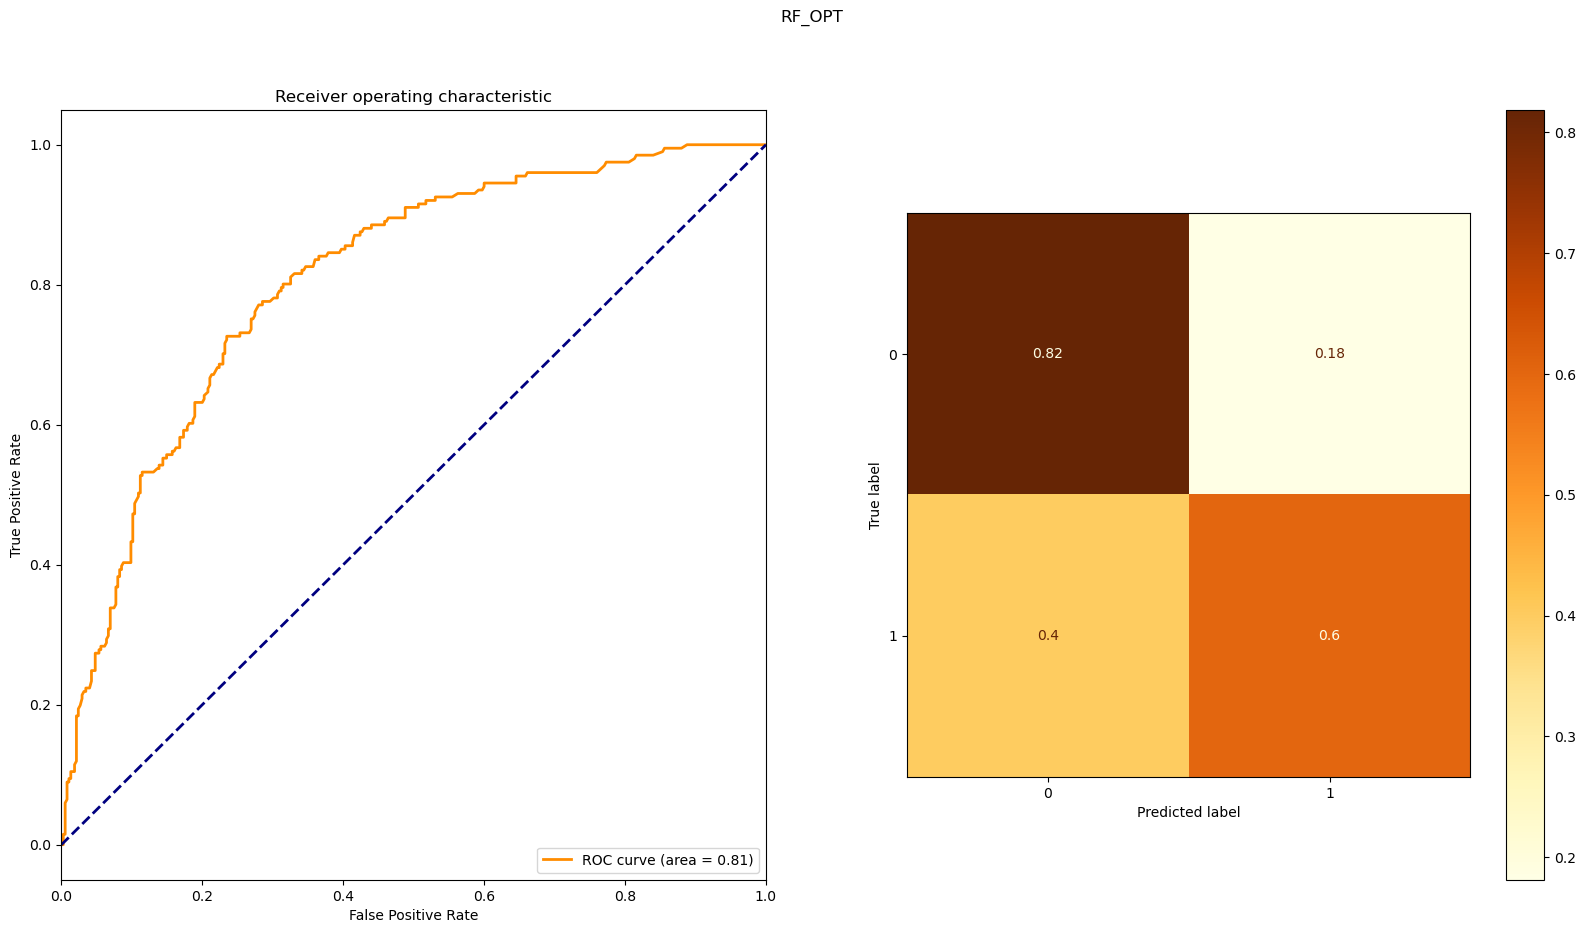

In [42]:
model_list.set_params('RF_OPT', n_estimators=best_n, max_features=best_features, criterion=best_criterion, class_weight=best_class_weight)
model_list.initialize(model_key='RF_OPT')
model_list.fit(model_key='RF_OPT')
model_list.predict(model_key='RF_OPT')

model_list.get_model_metrics('RF_OPT')

Создаем новую модель градиентного бустинга, подбираем лучшие параметры.

In [43]:
model_list['GB_OPT'] = GradientBoostingClassifier

loss_range = ['log_loss', 'exponential']
rate_range = [float(10**(power / 100)) for power in range(-200, 201)]
n_range = [int(10**(i / 10)) for i in range(0, 31)]
criterion_range = ['friedman_mse', 'squared_error']
param_grid = dict(loss=loss_range, learning_rate=rate_range, n_estimators=n_range, criterion=criterion_range)

rs = RandomizedSearchCV(model_list.classes['GB_OPT'](), param_grid, scoring='balanced_accuracy')
random_search=rs.fit(X_train.to_numpy(), y_train.to_numpy().flatten())

best_loss = random_search.best_params_['loss']
best_rate = random_search.best_params_['learning_rate']
best_n = random_search.best_params_['n_estimators']
best_criterion = random_search.best_params_['criterion']
best_loss, best_rate, best_n, best_criterion

D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py", line 525, in fit
    self._check_params()
  File "D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'log_loss' not 

('exponential', 0.5888436553555889, 25, 'friedman_mse')

Устанавливаем модели найденные лучшие параметры, вычисляем значения метрик, выводим графики для сравнения с baseline-моделью.

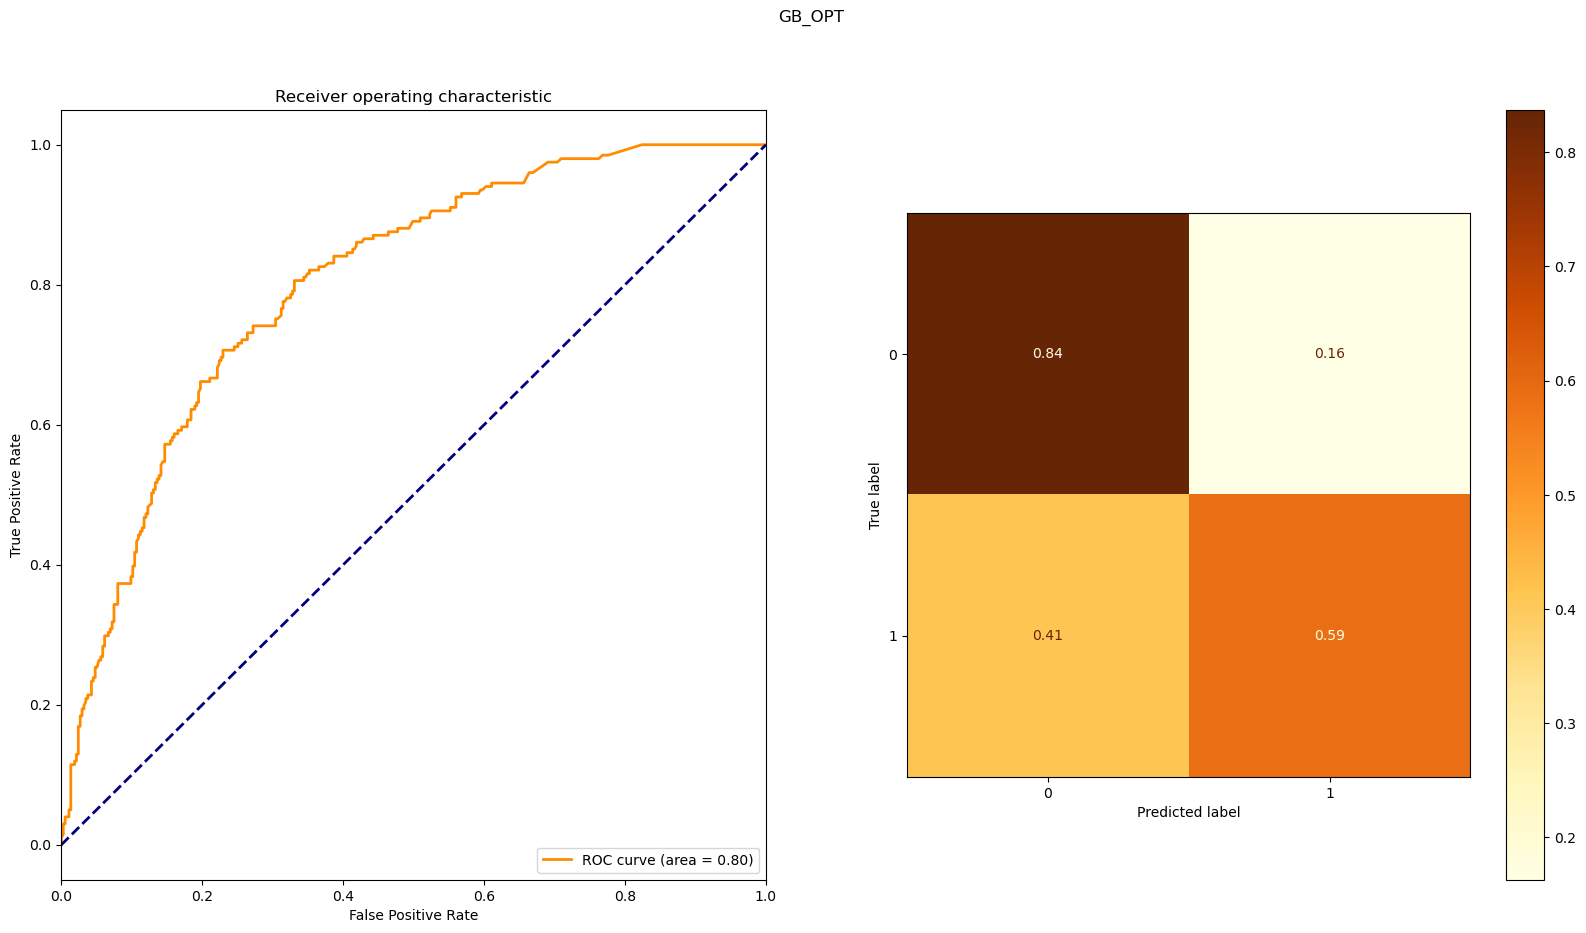

In [44]:
model_list.set_params('GB_OPT', loss=best_loss, learning_rate=best_rate, n_estimators=best_n, criterion=best_criterion)
model_list.initialize(model_key='GB_OPT')
model_list.fit(model_key='GB_OPT')
model_list.predict(model_key='GB_OPT')

model_list.get_model_metrics('GB_OPT')

### Формирование выводов о качестве построенных моделей на основе выбранных метрик.

Выведем значения каждой метрики для всех моделей.

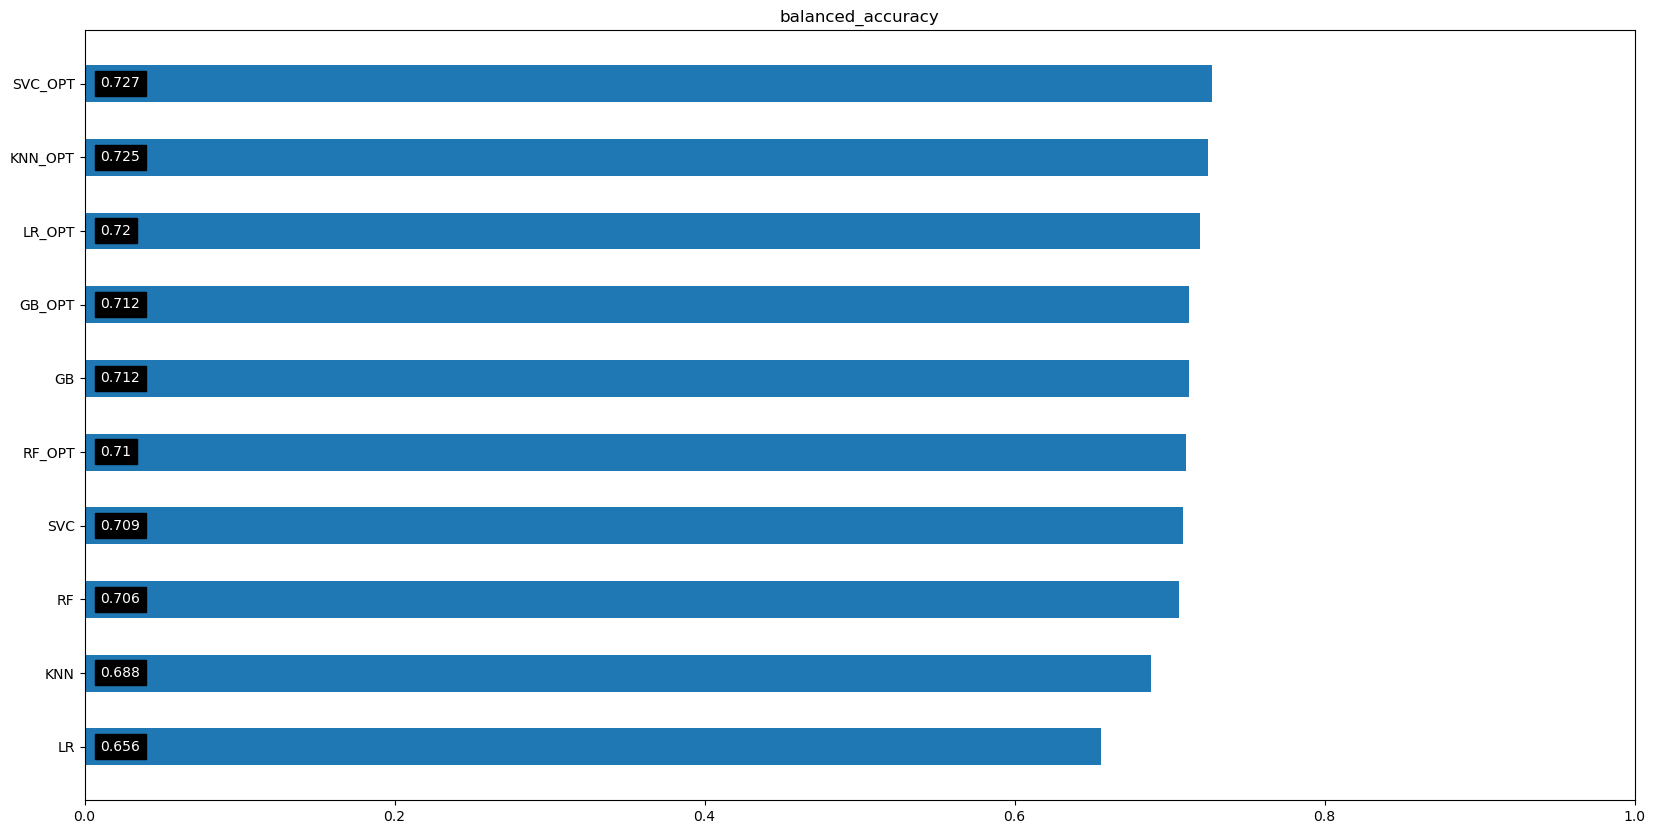

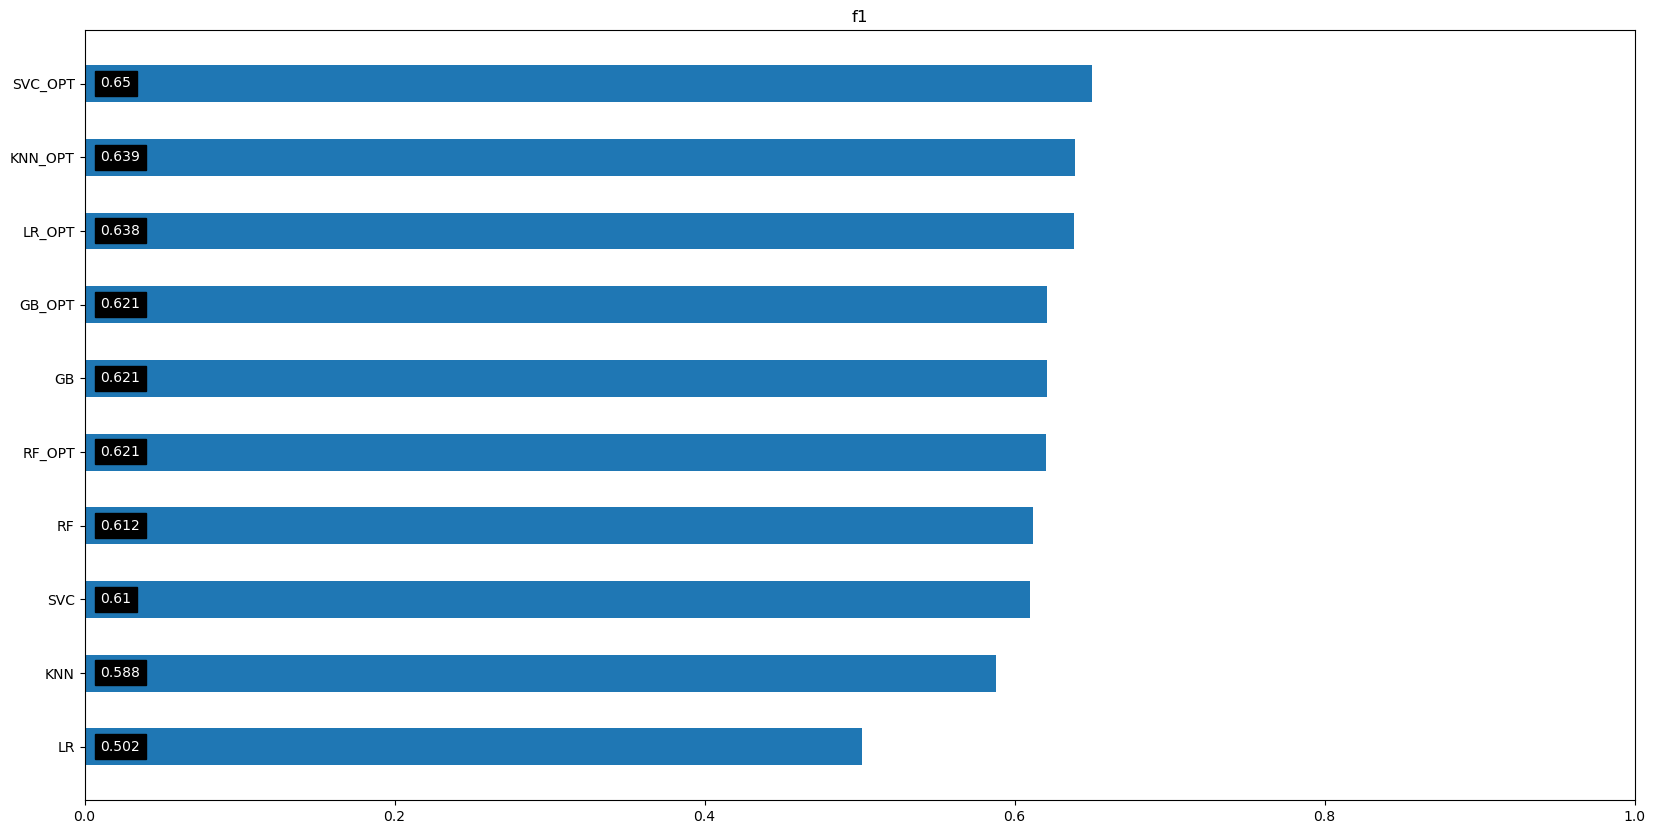

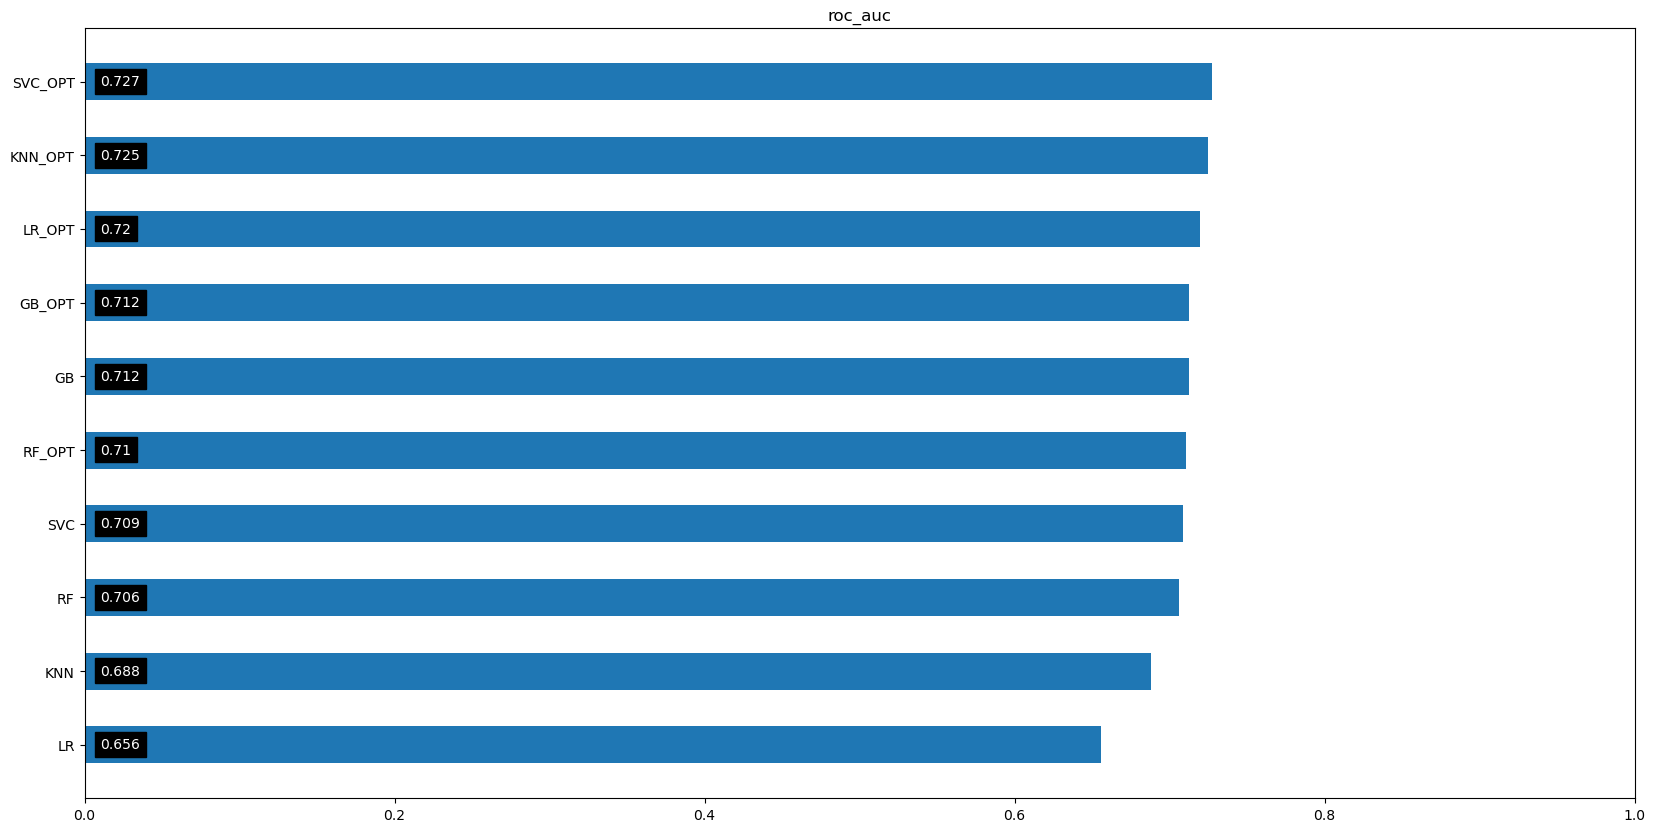

In [45]:
for metric_label in model_list.metrics:
    model_list.plot_metrics(metric_label)

**Выводы:**
- Оптимизация **метода ближайших соседей** привела к несколько *лучшим* результатам по всем метрикам
- Оптимизация **логистической регрессии** привела к несколько *лучшим* результатам по большинству метрикам
- Оптимизация **метода опорных векторов** привела к намного *худшим* результатам по всем метрикам
- Оптимизация **случайного леса привела** к несколько *лучшим* результатам по всем метрикам
- Оптимизация **градиентного бустинга** привела к несколько *худшим* результатам по всем метрикам
- Лучшие результаты были показаны методом **опорных векторов** 